# Analysis of Beijing Pollution and State Visit Data

The goal of my Master's thesis research is to develop a new methodology to better understand China’s international relations with other countries by tracking air pollution particulate matter readings. There is ample anecdotal evidence that Chinese authorities are able to exert control over pollution. For example, government officials carefully regulated pollution prior to the 2008 Beijing Olympics. This raises the question of whether the government has sought to control the level of pollution during other politically important events. Official visits to China from representatives of foreign governments could be one such type of events. My approach exploits the relationship between daily pollution levels and the timing of diplomatic meetings in Beijing to quantify how the Chinese government views its relations with different countries. Moreover, I also plan to strengthen this causal relationship by exploiting variation in weather patterns and how it relates to air pollution as a natural experiment. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import datetime
import os
import json
import regex as re
import csv
import openpyxl
import statsmodels.api as sm
from statsmodels.stats.weightstats import ttest_ind
import scipy.stats as sp
from statsmodels.iolib.summary2 import summary_col

%matplotlib inline

# Part I: Pollution data

Data on AQI (air quality index) comes from the US State Department.

In [2]:
pollution_data = pd.DataFrame()
for i in range(8,19):
    year = 2000 + i
    filepath = 'data/Beijing_PM2.5_'+str(year)+'_YTD.csv'
    print(filepath)
    pollution_data = pd.concat([pollution_data, pd.read_csv(filepath, encoding='utf-8')])
    
pollution_data['Date (LT)'] = pd.to_datetime(pollution_data['Date (LT)'])
pollution_data = pollution_data.reset_index(drop=True)
pollution_data.drop(pollution_data.tail(1).index,inplace=True) # drop 1 row with 2019 data
pollution_data.tail()

data/Beijing_PM2.5_2008_YTD.csv
data/Beijing_PM2.5_2009_YTD.csv
data/Beijing_PM2.5_2010_YTD.csv
data/Beijing_PM2.5_2011_YTD.csv
data/Beijing_PM2.5_2012_YTD.csv
data/Beijing_PM2.5_2013_YTD.csv
data/Beijing_PM2.5_2014_YTD.csv
data/Beijing_PM2.5_2015_YTD.csv
data/Beijing_PM2.5_2016_YTD.csv
data/Beijing_PM2.5_2017_YTD.csv
data/Beijing_PM2.5_2018_YTD.csv


,Site,Parameter,Date (LT),Year,Month,Day,Hour,NowCast Conc.,AQI,AQI Category,Raw Conc.,Conc. Unit,Duration,QC Name
96426,Beijing,PM2.5 - Principal,2018-12-31 19:00:00,2018,12,31,19,57.0,152,Unhealthy,59.0,UG/M3,1 Hr,Valid
96427,Beijing,PM2.5 - Principal,2018-12-31 20:00:00,2018,12,31,20,61.0,154,Unhealthy,65.0,UG/M3,1 Hr,Valid
96428,Beijing,PM2.5 - Principal,2018-12-31 21:00:00,2018,12,31,21,61.0,154,Unhealthy,61.0,UG/M3,1 Hr,Valid
96429,Beijing,PM2.5 - Principal,2018-12-31 22:00:00,2018,12,31,22,55.0,149,Unhealthy for Sensitive Groups,49.0,UG/M3,1 Hr,Valid
96430,Beijing,PM2.5 - Principal,2018-12-31 23:00:00,2018,12,31,23,54.4,148,Unhealthy for Sensitive Groups,53.0,UG/M3,1 Hr,Valid


#### Compare line counts of original data files using `$ wc -l <filename>` with shape of dataframe

Each smaller dataframe should have 4 fewer lines, accountings for data descriptions, spacings and headers

In [3]:
# Line check looks good!
8785 + 8761 + 8761 + 8761 + 8785 + 8761 + 8761 + 8761 + 8785 + 8761 + 8760 - 11 #(extra line at the end of each file)

96431

In [4]:
pollution_data = pollution_data.rename(columns={'Site':'site'
                        ,'Parameter':'parameter'
                        ,'Date (LT)':'date_lt'
                        ,'Year':'year'
                        ,'Month':'month'
                        ,'Day':'day'
                        ,'Hour':'hour'
                        ,'NowCast Conc.':'nowcast_conc'
                        ,'AQI':'aqi'
                        ,'AQI Category':'aqi_category'
                        ,'Raw Conc.':'raw_conc'
                        ,'Conc. Unit':'conc_unit'
                        ,'Duration':'duration'
                        ,'QC Name':'qc_name'})
pollution_data.head()

,site,parameter,date_lt,year,month,day,hour,nowcast_conc,aqi,aqi_category,raw_conc,conc_unit,duration,qc_name
0,Beijing,PM2.5 - Principal,2008-01-01 01:00:00,2008,1,1,1,-999.0,-999,NaN,-999.0,UG/M3,1 Hr,Missing
1,Beijing,PM2.5 - Principal,2008-01-01 02:00:00,2008,1,1,2,-999.0,-999,NaN,-999.0,UG/M3,1 Hr,Missing
2,Beijing,PM2.5 - Principal,2008-01-01 03:00:00,2008,1,1,3,-999.0,-999,NaN,-999.0,UG/M3,1 Hr,Missing
3,Beijing,PM2.5 - Principal,2008-01-01 04:00:00,2008,1,1,4,-999.0,-999,NaN,-999.0,UG/M3,1 Hr,Missing
4,Beijing,PM2.5 - Principal,2008-01-01 05:00:00,2008,1,1,5,-999.0,-999,NaN,-999.0,UG/M3,1 Hr,Missing


#### Check how many records are Invalid or Missing

In [5]:
print(pollution_data.groupby('qc_name').size())
print('\nPercent values missing: ', round(6765.0/94968, 3))
print('Percent values invalid: ', round(4037.0/94968, 3)) # negative raw_conc
print('Percent values valid: ', round(84166.0/94968, 3))

qc_name
Invalid     4043
Missing     4413
Valid      87975
dtype: int64

Percent values missing:  0.071
Percent values invalid:  0.043
Percent values valid:  0.886


### Pollution data: Exploratory analysis

#### Fill missing AQI values, and convert date field to datetime type

In [6]:
def fill_missing(x):
    if x < 0:
        return None
    else:
        return x
    
a = fill_missing(-1)
print(a)

None


In [7]:
pollution_data['aqi'] = pollution_data.aqi.apply(fill_missing)
pollution_data[pollution_data.qc_name == 'Missing'] #looks good
pollution_data.head()

,site,parameter,date_lt,year,month,day,hour,nowcast_conc,aqi,aqi_category,raw_conc,conc_unit,duration,qc_name
0,Beijing,PM2.5 - Principal,2008-01-01 01:00:00,2008,1,1,1,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
1,Beijing,PM2.5 - Principal,2008-01-01 02:00:00,2008,1,1,2,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
2,Beijing,PM2.5 - Principal,2008-01-01 03:00:00,2008,1,1,3,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
3,Beijing,PM2.5 - Principal,2008-01-01 04:00:00,2008,1,1,4,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
4,Beijing,PM2.5 - Principal,2008-01-01 05:00:00,2008,1,1,5,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing


##### Hourly pollution readings over time, 2008 through 2018

In [8]:
dates = [pollution_data.date_lt.values]
dates[:5]

[array(['2008-01-01T01:00:00.000000000', '2008-01-01T02:00:00.000000000',
        '2008-01-01T03:00:00.000000000', ...,
        '2018-12-31T21:00:00.000000000', '2018-12-31T22:00:00.000000000',
        '2018-12-31T23:00:00.000000000'], dtype='datetime64[ns]')]

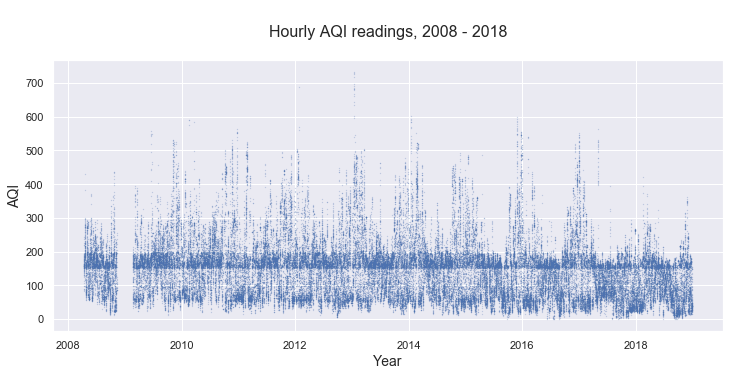

In [180]:
sns.set(style="darkgrid", color_codes=True)

y = pollution_data.aqi

plt.figure(figsize=(12,5))
plt.scatter(dates, y, alpha=0.5, s=.05)
plt.title('\nHourly AQI readings, 2008 - 2018\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('AQI', size=14)
plt.savefig(os.getcwd() + '/img/pollution/1_hourly_aqi_over_time.png')

#### Yearly average coming down over time, from a  peak in 2013

In [12]:
yr_avg_aqi = pollution_data[pollution_data.qc_name == 'Valid'].groupby('year')['aqi'].mean().reset_index()
yr_avg_aqi.head()

,year,aqi
0,2008,151.063257
1,2009,166.381023
2,2010,166.886355
3,2011,160.396297
4,2012,151.744807


c:\users\joey\wuran\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\joey\wuran\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


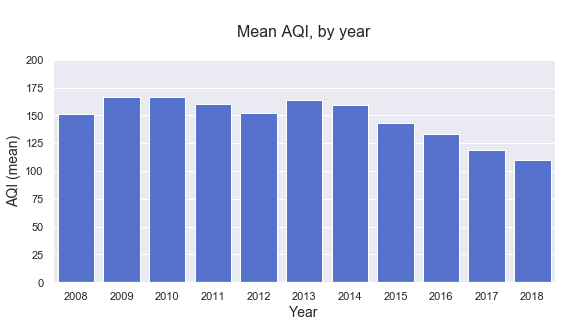

In [13]:
sns.set(style="darkgrid", color_codes=True)

f = sns.factorplot(x="year", y="aqi", data=yr_avg_aqi, kind="bar", aspect=2, size=4, color="royalblue", legend=False
              )

plt.title('\nMean AQI, by year\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('AQI (mean)', size=14)
plt.ylim(0,200)
f.savefig(os.getcwd() + '/img/pollution/2_yearly_aqi.png')

##### Winter months tend to be worse, with November highest

In [14]:
mo_avg_aqi = pollution_data[pollution_data.qc_name == 'Valid'].groupby('month')['aqi'].mean().reset_index()
mo_avg_aqi.head()

,month,aqi
0,1,156.286916
1,2,154.327449
2,3,150.428033
3,4,144.201400
4,5,143.319491


c:\users\joey\wuran\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\joey\wuran\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


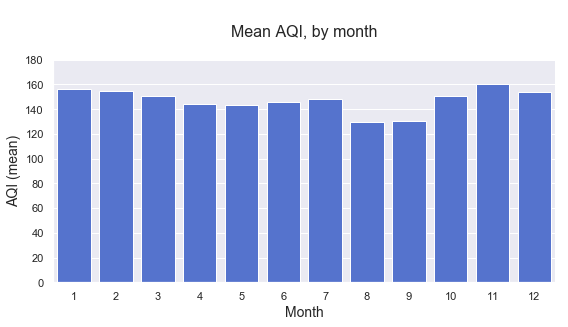

In [19]:
sns.set(style="darkgrid", color_codes=True)

f = sns.factorplot(x="month", y="aqi", data=mo_avg_aqi, kind="bar", aspect=2, size=4, color="royalblue", legend=False)

plt.title('\nMean AQI, by month\n', size=16)
plt.xlabel('Month', size=14)
plt.ylabel('AQI (mean)', size=14)
plt.ylim(0,180)
f.savefig(os.getcwd() + '/img/pollution/3_monthly_aqi.png')

##### Pollution tends to be worse at night

In [20]:
hr_avg_aqi = pollution_data[pollution_data.qc_name == 'Valid'].groupby('hour')['aqi'].mean().reset_index()
hr_avg_aqi.head()

,hour,aqi
0,0,158.161175
1,1,158.203694
2,2,157.171756
3,3,156.164817
4,4,153.839034


c:\users\joey\wuran\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\joey\wuran\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


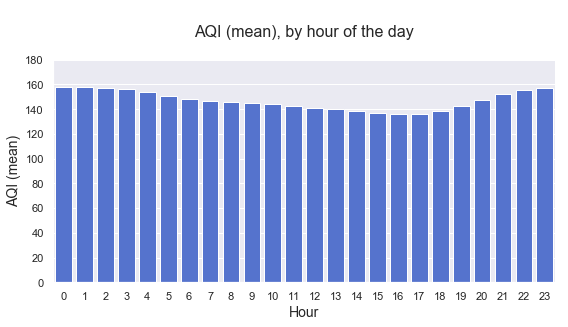

In [21]:
sns.set(style="darkgrid", color_codes=True)

f = sns.factorplot(x="hour", y="aqi", data=hr_avg_aqi, kind="bar", aspect=2, size=4, color="royalblue", legend=False)

plt.title('\nAQI (mean), by hour of the day\n', size=16)
plt.xlabel('Hour', size=14)
plt.ylabel('AQI (mean)', size=14)
plt.ylim(0,180)
f.savefig(os.getcwd() + '/img/pollution/4_hourly_aqi.png')

##### Max AQI values per day, 2008 through 2018

In [22]:
m = pollution_data.groupby(pollution_data.date_lt.apply(lambda x: x.date()))['aqi'].max().reset_index()
m = m.rename(columns={'aqi':'max_aqi'})
m.tail()

,date_lt,max_aqi
4013,2018-12-27,56.0
4014,2018-12-28,43.0
4015,2018-12-29,57.0
4016,2018-12-30,89.0
4017,2018-12-31,154.0


Concentration (ug/m^3) to AQI conversion taken from [AQICN](http://aqicn.org/calculator)

![Screenshot from aqicn.org](https://github.com/yontartu/wuran/raw/master/img/aqicn.png)

Tool to convert color names to RGB. Find named colors [here](https://matplotlib.org/examples/color/named_colors.html).

In [23]:
from matplotlib import colors
colors.hex2color(colors.cnames['salmon'])

(0.9803921568627451, 0.5019607843137255, 0.4470588235294118)

In [24]:
a = m[m.max_aqi <= 12]
b = m[(m.max_aqi > 12) & (m.max_aqi <= 35.5)]
c = m[(m.max_aqi > 35.5) & (m.max_aqi <= 55.5)]
d = m[(m.max_aqi > 55.5) & (m.max_aqi <= 150.5)]
e = m[(m.max_aqi > 150.5) & (m.max_aqi <= 250.5)]
f = m[(m.max_aqi > 250.5) & (m.max_aqi <= 500.5)]
g = m[(m.max_aqi > 500.5)]

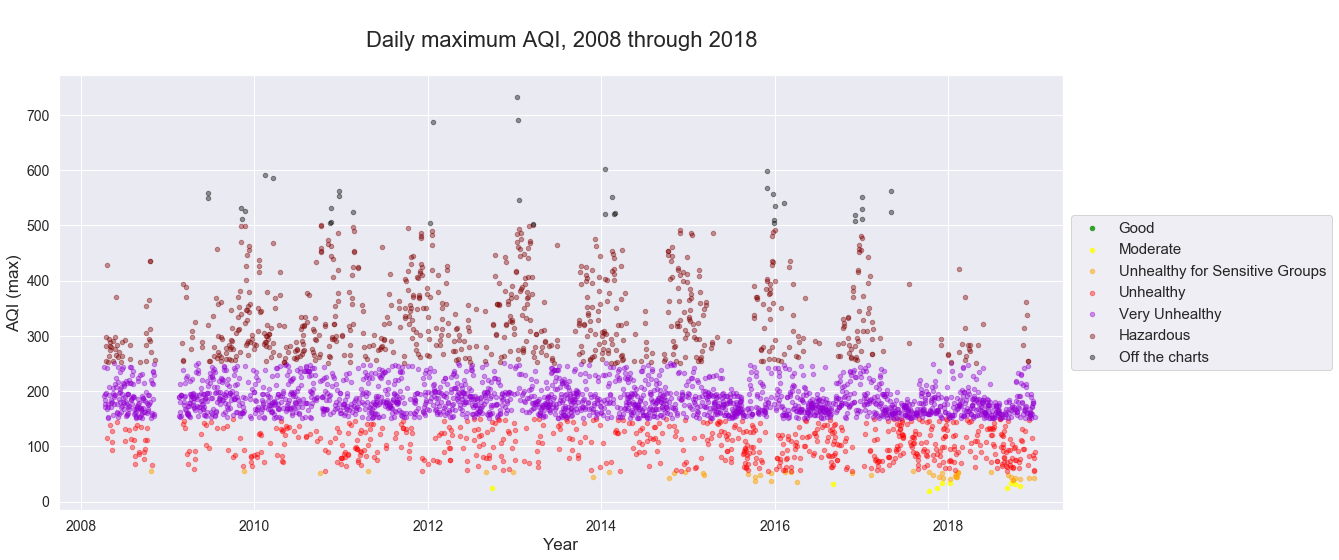

In [25]:
plt.figure(figsize=(18,8))
plt.scatter(list(a.date_lt), a.max_aqi, alpha=1.0, s=20, c=[[0.2, 0.6274509803921569, 0.17254901960784313]], label='Good')
plt.scatter(list(b.date_lt), b.max_aqi, alpha=0.8, s=20, c=[[1.0, 1.0, 0.0]], label='Moderate')
plt.scatter(list(c.date_lt), c.max_aqi, alpha=0.5, s=20, c=[[1.0, 0.6470588235294118, 0.0]], label='Unhealthy for Sensitive Groups')
plt.scatter(list(d.date_lt), d.max_aqi, alpha=0.4, s=20, c=[[1.0, 0.0, 0.0]], label='Unhealthy')
plt.scatter(list(e.date_lt), e.max_aqi, alpha=0.4, s=20, c=[[0.5803921568627451, 0.0, 0.8274509803921568]], label='Very Unhealthy')
plt.scatter(list(f.date_lt), f.max_aqi, alpha=0.4, s=20, c=[[0.5019607843137255, 0.0, 0.0]], label='Hazardous')
plt.scatter(list(g.date_lt), g.max_aqi, alpha=0.4, s=20, c=[[0.0, 0.0, 0.0]], label='Off the charts')
plt.xlim(datetime.date(2007,10,1), datetime.date(2019,5,1))
plt.title('\nDaily maximum AQI, 2008 through 2018\n', size=22)
plt.ylabel('AQI (max)', size=17)
plt.xlabel('Year', size=17)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='center right', bbox_to_anchor=(1.275, 0.5), fontsize=15)
plt.savefig(os.getcwd() + '/img/pollution/5_daily_max_aqi.png')

Is the number of **"Good"** and **"Moderate"** days increasing or decreasing? What about the number of **"Unhealthy"** and **"Hazardous"** days?

In [26]:
pollution_data.head()

,site,parameter,date_lt,year,month,day,hour,nowcast_conc,aqi,aqi_category,raw_conc,conc_unit,duration,qc_name
0,Beijing,PM2.5 - Principal,2008-01-01 01:00:00,2008,1,1,1,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
1,Beijing,PM2.5 - Principal,2008-01-01 02:00:00,2008,1,1,2,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
2,Beijing,PM2.5 - Principal,2008-01-01 03:00:00,2008,1,1,3,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
3,Beijing,PM2.5 - Principal,2008-01-01 04:00:00,2008,1,1,4,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
4,Beijing,PM2.5 - Principal,2008-01-01 05:00:00,2008,1,1,5,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing


In [27]:
s = pollution_data.groupby([pollution_data.year, pollution_data.aqi_category]).size().reset_index()
s = s.rename(columns={s.columns[2]:'counts'})
s.head()

,year,aqi_category,counts
0,2008,Good,213
1,2008,Hazardous,37
2,2008,Moderate,911
3,2008,Unhealthy,2224
4,2008,Unhealthy for Sensitive Groups,807


c:\users\joey\wuran\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\joey\wuran\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


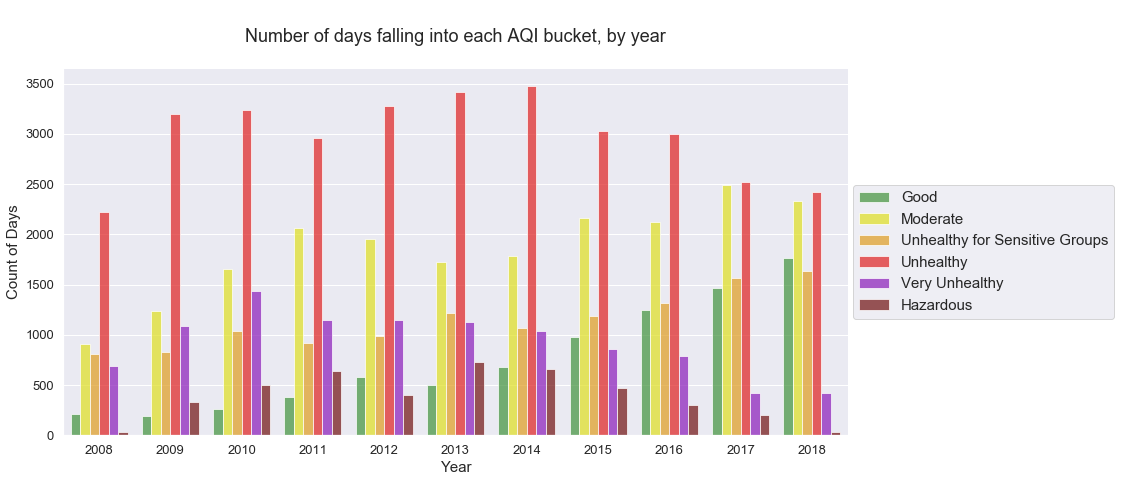

In [28]:
sns.set(style="darkgrid", color_codes=True)

p = sns.set_palette([
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (1.0, 1.0, 0.0),
 (1.0, 0.6470588235294118, 0.0),
 (1.0, 0.0, 0.0),
 (0.5803921568627451, 0.0, 0.8274509803921568),
 (0.5019607843137255, 0.0, 0.0),
 (0.0, 0.0, 0.0)
])


f = sns.factorplot(x="year", y="counts", hue="aqi_category", data=s, kind="bar", aspect=2, size=6, alpha=.7
               , hue_order=['Good','Moderate','Unhealthy for Sensitive Groups','Unhealthy','Very Unhealthy','Hazardous'
                            ]
               , palette=p
               , legend=False
              )

plt.title('\nNumber of days falling into each AQI bucket, by year\n', size=18)
plt.xlabel('Year', size=15)
plt.ylabel('Count of Days', size=15)
plt.xticks(size=13)
plt.yticks(size=13)
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), fontsize=15)
f.savefig(os.getcwd() + '/img/pollution/6_aqi_buckets_by_year.png')

# Part II: State Visit data

Data on state visits comes from chinavitae.com. I constructed my own dataset using a web scraper I built. I also wrote separate Python scripts to scrape foreign officials' titles, and to extract country names from officials' titles.

In [29]:
filename = 'C:data/activity_titles_countries.json'
with open(filename, 'r') as f:
    cv = json.load(f)
print(len(cv)) # 16695 items
cv[8]

16695


{'date': 'January 25, 2019',
 'activity': 'Xi extends Spring Festival greetings to journalists',
 'location': 'Beijing Municipality',
 'attendees': ['Xi Jinping'],
 'attendees_links': ['index.php?mode=events&type=cv&id=303'],
 'source': 'XINHUA Online (English 2010)',
 'topics': ['domestic politics', 'media'],
 'foreign_officials': [],
 'activity_id': 8,
 'matched_countries': [],
 'matched_on': []}

#### Convert date field to datetime

In [31]:
for record in cv:
    if record['date'] != None:
        record['date'] = datetime.datetime.strptime(record['date'], '%B %d, %Y').date()
#     print(record)
cv[0]

{'date': datetime.date(2019, 2, 3),
 'activity': 'Zhang Youxia calls for support of strengthening and revitalizing armed forces ',
 'location': 'Beijing Municipality',
 'attendees': ['Zhang Youxia'],
 'attendees_links': ['index.php?mode=events&type=cv&id=4098'],
 'source': 'XINHUA Online (English 2010)',
 'topics': ['domestic politics', 'military'],
 'foreign_officials': [],
 'activity_id': 0,
 'matched_countries': [],
 'matched_on': []}

In [32]:
huwen = []
for record in cv:
    if record['date'] != None:
        if record['date'] < datetime.date(2013,3,14): # CHANGE DATE 
            if any("hu jintao" in a.lower() for a in record['attendees']) or any("wen jiabao" in a.lower() for a in record['attendees']):
                huwen.append(record)
print('len of huwen:', len(huwen))

len of huwen: 3021


In [33]:
xili = []
for record in cv:
    if record['date'] != None:
        if record['date'] >= datetime.date(2013,3,14): # CHANGE DATE
            if any("xi jinping" in a.lower() for a in record['attendees']) or any("li keqiang" in a.lower() for a in record['attendees']):
                xili.append(record)
print('len of xili:', len(xili))

len of xili: 2989


In [34]:
huxiwenli = huwen + xili
len(huxiwenli)

6010

### Create subset of State Visit data for analysis: meetings with the Chinese President or Premier

#### Definition of `hxwl` (shorthand for `huxiwenli`)
1. Contains Hu Jingtao, Xi Jinping, Wen Jiabao or Li Keqiang in the list of attendees (already filtered down to this subset)
2. Number of attendees > 1
3. Number of foreign officials attending > 0 
4. Filter out meetings that did not occur in Beijing (i.e. records with "phone" or "send" or "leave" or "congratulat" or "condolence" or "message" or "greeting" or "return" or "anniversar")
5. Official's title contains a country name

In [35]:
hxwl = []
for record in huxiwenli:
    # condition (2): at least 2 attendees
    if len(record['attendees']) > 1:  

        # condition (3): at least 1 foreign official
        if len(record['foreign_officials']) > 0: 

            # condition (4): meeting actually occurred in beijing
            if "phone" not in record['activity'].lower():
                if "leave" not in record['activity'].lower():
                    if "send" not in record['activity'].lower():
                        if "congratulat" not in record['activity'].lower():
                            if "condolence" not in record['activity'].lower():
                                if "message" not in record['activity'].lower():
                                    if "greeting" not in record['activity'].lower():
                                        if "return" not in record['activity'].lower():
                                            if "anniversar" not in record['activity'].lower():
                                                hxwl.append(record)

print('len of hxwl: ', len(hxwl)) # 1774 records 

len of hxwl:  1774


In [36]:
hxwl_matched = []
hxwl_unmatched = []

for record in hxwl:
    # condition (5): matched on country name
    if len(record['matched_countries']) > 0:
        hxwl_matched.append(record)
    else:
        hxwl_unmatched.append(record)

print('len of hxwl_matched: ', len(hxwl_matched)) # 1597 (used to be 999)
print('len of hxwl_unmatched: ', len(hxwl_unmatched)) # 177 (used to be 105)

len of hxwl_matched:  1597
len of hxwl_unmatched:  177


In [37]:
hxwl_matched[0]

{'date': datetime.date(2011, 4, 18),
 'activity': "Chinese Premier meets Singapore's Senior Minister on bilateral ties",
 'location': 'Beijing Municipality',
 'attendees': ['Wen Jiabao', '\n\t\t\t\t\tChok Tong Goh'],
 'attendees_links': ['index.php?mode=events&type=cv&id=21',
  'index.php?mode=events&type=ncv&sn=Goh&gn=Chok Tong'],
 'source': 'XINHUA Online (China View)',
 'topics': ['foreign relations'],
 'foreign_officials': [{'name': 'Chok Tong Goh',
   'title': 'Senior Minister of Singapore'}],
 'activity_id': 244,
 'matched_countries': ['singapore'],
 'matched_on': ['country']}

### Create alternate subset of State Visit data: all foreign visits (not just with `hxwl`) 

#### Definition of `all_visits` 
2. Number of attendees > 1
3. Number of foreign officials attending > 0 
4. Filter out meetings that did not occur in Beijing (i.e. records with "phone" or "send" or "leave" or "congratulat" or "condolence" or "message" or "greeting" or "return" or "anniversar")
5. Official's title contains a country name

In [38]:
all_visits = []
for record in cv:
    # condition (2): at least 2 attendees
    if len(record['attendees']) > 1:  

        # condition (3): at least 1 foreign official
        if len(record['foreign_officials']) > 0: 

            # condition (4): meeting actually occurred in beijing
            if "phone" not in record['activity'].lower():
                if "leave" not in record['activity'].lower():
                    if "send" not in record['activity'].lower():
                        if "congratulat" not in record['activity'].lower():
                            if "condolence" not in record['activity'].lower():
                                if "message" not in record['activity'].lower():
                                    if "greeting" not in record['activity'].lower():
                                        if "return" not in record['activity'].lower():
                                            if "anniversar" not in record['activity'].lower():
                                                all_visits.append(record)

print('len of all_visits: ', len(all_visits)) # 6488 records 

len of all_visits:  6488


In [39]:
all_visits_matched = []
all_visits_unmatched = []

for record in all_visits:
    # condition (5): matched on country name
    if len(record['matched_countries']) > 0:
        all_visits_matched.append(record)
    else:
        all_visits_unmatched.append(record)

print('len of all_visits_matched: ', len(all_visits_matched)) # 5604 
print('len of all_visits_unmatched: ', len(all_visits_unmatched)) # 884

len of all_visits_matched:  5604
len of all_visits_unmatched:  884


In [40]:
all_visits_matched[10]

{'date': datetime.date(2017, 1, 9),
 'activity': 'China, Uruguay pledge to enhance cooperation via parliamentary exchanges',
 'location': 'Beijing Municipality',
 'attendees': ['Zhang Dejiang', '\n\t\t\t\t\tGerardo Amarilla'],
 'attendees_links': ['index.php?mode=events&type=cv&id=35',
  'index.php?mode=events&type=ncv&sn=Amarilla&gn=Gerardo'],
 'source': 'XINHUA Online (China View)',
 'topics': ['foreign relations'],
 'foreign_officials': [{'name': 'Gerardo Amarilla',
   'title': "President of Chamber of Representatives of Uruguay's National Congress"}],
 'activity_id': 60,
 'matched_countries': ['uruguay'],
 'matched_on': ['country']}

### Construct main dataframe: Each row is 1 unique day between 2003 and 2019

Currently, each row in the `hxwl` dataset is an activity record of a meeting between the Chinese president and foreign officials. For my analysis, I want to construct a dataset where each row corresponds to a unique day, and contains information on all the countries from which representatives met with the Chinese president on that day.

Alternatively, use `all_visits_matched` for a larger subsample.

In [41]:
df = pd.DataFrame(hxwl_matched) # convert hxwl_matched to a df
df = df[['date','matched_countries','attendees','foreign_officials','activity', 'activity_id']]
df.head()
print(df.shape)
df[330:335]

(1597, 6)


,date,matched_countries,attendees,foreign_officials,activity,activity_id
330,2005-06-21,[republic of korea],"[Wen Jiabao, Ma Kai, \n\t\t\t\t\t Lee Hae-chan]","[{'name': 'Lee Hae-chan', 'title': 'Prime Mini...",Wen Jiabao held talks with South Korean Prime ...,2741
331,2005-06-21,[jamaica],"[Hu Jintao, \n\t\t\t\t\tPercival Noel James Pa...","[{'name': 'Percival Noel James Patterson', 'ti...",Hu Jintao met with Percival Noel James Patters...,2742
332,2005-06-22,[republic of korea],"[Hu Jintao, \n\t\t\t\t\t Lee Hae-chan]","[{'name': 'Lee Hae-chan', 'title': 'Prime Mini...",Hu Jintao met with South Korean Prime Ministe...,2751
333,2005-06-25,[czech republic],"[Hu Jintao, Tang Jiaxuan, \n\t\t\t\t\tJiri Par...","[{'name': 'Jiri Paroubek', 'title': 'Prime Min...",Hu Jintao met with Czech Prime Minister Jiri P...,2757
334,2005-06-25,[fiji],"[Hu Jintao, Tang Jiaxuan, \n\t\t\t\t\tLaisenia...","[{'name': 'Laisenia Qarase', 'title': 'Prime M...",Hu Jintao met with Fijian Prime Minister Laise...,2759


#### Combine all lists of `matched_countries` on a given date

For example, on Febuary 27, 2003, two meetings with Hu Jintao occured: one with Cuba and one with Russia

In [42]:
df[df.date == datetime.date(2003,2,27)]

,date,matched_countries,attendees,foreign_officials,activity,activity_id
7,2003-02-27,[cuba],"[Hu Jintao, Li Peng, Wen Jiabao, Zhu Rongji, \...","[{'name': 'Fidel Castro', 'title': 'Leader of ...","Hu Jintao held talks with Fidel Castro, Presid...",412
8,2003-02-27,[russia],"[Hu Jintao, Jiang Zemin, Tang Jiaxuan, \n\t\t\...","[{'name': 'Igor Ivanov', 'title': 'Russian For...",Jiang Zemin held talks with Russian Foreign Mi...,414


In [43]:
df = df.groupby('date').agg({'matched_countries': 'sum'})#.reset_index()
df.matched_countries = df.matched_countries.apply(lambda x: list(set(x)))
print(df.shape)
df.head()

(1082, 1)


,matched_countries
date,
2003-02-17,[united states]
2003-02-27,"[russia, cuba]"
2003-03-25,[pakistan]
2003-05-14,[romania]
2003-05-19,[japan]


#### Explode each list of `matched_countries` into separate columns

In [44]:
cos = df['matched_countries'].apply(pd.Series)
cos = cos.rename(columns=lambda x: 'country_'+str(x+1))
cos.head()

,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
date,,,,,,,,,
2003-02-17,united states,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-02-27,russia,cuba,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-03-25,pakistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-14,romania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-19,japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Merge dataframe with `matched_countries` list with exploded country columns

In [45]:
df = pd.concat([df[:], cos[:]], axis=1)#.shape
df = df.sort_values(by=['date'], ascending=False).reset_index()

In [46]:
print(df.shape)
df.tail()

(1082, 11)


,date,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
1077,2003-05-19,[japan],japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1078,2003-05-14,[romania],romania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1079,2003-03-25,[pakistan],pakistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1080,2003-02-27,"[russia, cuba]",russia,cuba,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1081,2003-02-17,[united states],united states,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Create base df with ALL DAYS from 2019 through 2003

In [47]:
df_basedates = pd.DataFrame({'date':list(reversed(pd.date_range('1/1/2003', '2/3/2019')))})
df_basedates.date = df_basedates.date.apply(lambda x: x.date())
print('shape:', df_basedates.shape)
df_basedates.head()

shape: (5878, 1)


,date
0,2019-02-03
1,2019-02-02
2,2019-02-01
3,2019-01-31
4,2019-01-30


#### Merge base df with country matches

In [48]:
df_merged = pd.merge(df_basedates, df, how='left', on='date')
print('shape:', df_merged.shape)
df_merged.head()

shape: (5878, 11)


,date,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,2019-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Create a `state_visit` variable, that takes value 1 if a state visit occured on that day, 0 otherwise

In [49]:
df_merged['state_visit'] = df_merged.matched_countries.isnull() == False
df_merged['state_visit'] = df_merged['state_visit'].astype(int)
print(df_merged.shape)
df_merged.head()

(5878, 12)


,date,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit
0,2019-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2019-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2019-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2019-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [50]:
df_merged[df_merged.state_visit == True].tail()

,date,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit
5739,2003-05-19,[japan],japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5744,2003-05-14,[romania],romania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5794,2003-03-25,[pakistan],pakistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5820,2003-02-27,"[russia, cuba]",russia,cuba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5830,2003-02-17,[united states],united states,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# Part III: Merge pollution data with state visits data

In [51]:
pollution = pollution_data.copy()
print('pollution data shape:', pollution.shape)
pollution.head()

pollution data shape: (96431, 14)


,site,parameter,date_lt,year,month,day,hour,nowcast_conc,aqi,aqi_category,raw_conc,conc_unit,duration,qc_name
0,Beijing,PM2.5 - Principal,2008-01-01 01:00:00,2008,1,1,1,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
1,Beijing,PM2.5 - Principal,2008-01-01 02:00:00,2008,1,1,2,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
2,Beijing,PM2.5 - Principal,2008-01-01 03:00:00,2008,1,1,3,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
3,Beijing,PM2.5 - Principal,2008-01-01 04:00:00,2008,1,1,4,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing
4,Beijing,PM2.5 - Principal,2008-01-01 05:00:00,2008,1,1,5,-999.0,NaN,NaN,-999.0,UG/M3,1 Hr,Missing


#### Calculate mean AQI by day

Each row in the pollution dataset is an hourly observation. I want to aggregate up to the daily level.

In [52]:
avg_aqi_by_day = pollution.groupby(pollution.date_lt.apply(lambda x: x.date()))['aqi'].mean().reset_index()
avg_aqi_by_day = avg_aqi_by_day.rename(columns={'date_lt':'date', 'aqi':'avg_aqi'})
print(avg_aqi_by_day.shape)
avg_aqi_by_day.tail()

(4018, 2)


,date,avg_aqi
4013,2018-12-27,36.125000
4014,2018-12-28,33.000000
4015,2018-12-29,38.458333
4016,2018-12-30,46.875000
4017,2018-12-31,111.208333


#### Calculate max AQI by day

In [53]:
max_aqi_by_day = pollution.groupby(pollution.date_lt.apply(lambda x: x.date()))['aqi'].max().reset_index()
max_aqi_by_day = max_aqi_by_day.rename(columns={'date_lt':'date', 'aqi':'max_aqi'})
print(max_aqi_by_day.shape)
max_aqi_by_day.tail()

(4018, 2)


,date,max_aqi
4013,2018-12-27,56.0
4014,2018-12-28,43.0
4015,2018-12-29,57.0
4016,2018-12-30,89.0
4017,2018-12-31,154.0


#### Merge mean and max AQI dataframes together

In [54]:
avg_max_aqi = pd.merge(avg_aqi_by_day, max_aqi_by_day, how='left',on='date')
print(avg_max_aqi.shape)
avg_max_aqi.head()

(4018, 3)


,date,avg_aqi,max_aqi
0,2008-01-01,NaN,NaN
1,2008-01-02,NaN,NaN
2,2008-01-03,NaN,NaN
3,2008-01-04,NaN,NaN
4,2008-01-05,NaN,NaN


#### Merge AQI dataframe with state visits dataframe

In [55]:
statevisits = df_merged.copy()
print(statevisits.shape)
statevisits.head()

(5878, 12)


,date,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit
0,2019-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2019-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2019-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2019-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [56]:
pollution_statevisits = pd.merge(avg_max_aqi, statevisits, how='left',on='date')
print(pollution_statevisits.shape)
pollution_statevisits.head()

(4018, 14)


,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit
0,2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2008-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2008-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2008-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2008-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


#### Reorder columns to make it easier to see key variables of interest

In [57]:
ps = pollution_statevisits.copy()
ps = ps[['date','avg_aqi','max_aqi','state_visit','matched_countries','country_1','country_2','country_3','country_4','country_5','country_6','country_7','country_8','country_9']]
print(ps.shape)
ps.head()

(4018, 14)


,date,avg_aqi,max_aqi,state_visit,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,2008-01-01,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-01-03,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-01-04,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-01-05,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Part IV: Import NOAA weather data

In [59]:
noaa_data = pd.DataFrame()
for i in range(8,19):
    year = 2000 + i
    filepath = 'data/noaa/isd_'+str(year)+'.csv'
    print(filepath)
    noaa_data = pd.concat([noaa_data, pd.read_csv(filepath)])

noaa_data.date = pd.to_datetime(noaa_data.date)
noaa_data = noaa_data.reset_index(drop=True)
noaa_data['wind_speed'] = noaa_data['wind_speed'] / 10 # apply scaling factor
noaa_data['tempc'] = noaa_data['tempc'] / 10 # apply scaling factor
noaa_data['atmpres'] = noaa_data['atmpres'] / 10 # apply scaling factor
print(noaa_data.shape)
noaa_data.tail()

data/noaa/isd_2008.csv
data/noaa/isd_2009.csv
data/noaa/isd_2010.csv
data/noaa/isd_2011.csv
data/noaa/isd_2012.csv
data/noaa/isd_2013.csv
data/noaa/isd_2014.csv
data/noaa/isd_2015.csv
data/noaa/isd_2016.csv
data/noaa/isd_2017.csv
data/noaa/isd_2018.csv
(202492, 7)


,date,wind_speed,wind_direction,wind_speed_quality,wind_obs_type,tempc,atmpres
202487,2018-12-31 21:30:00,2.0,340,1,N,-13.0,9999.9
202488,2018-12-31 22:00:00,3.0,350,1,N,-13.0,9999.9
202489,2018-12-31 22:30:00,3.0,350,1,N,-12.0,9999.9
202490,2018-12-31 23:00:00,2.0,360,1,N,-13.0,9999.9
202491,2018-12-31 23:30:00,3.0,360,1,N,-14.0,9999.9


In [60]:
noaa_data.describe()

,wind_speed,wind_direction,wind_speed_quality,tempc,atmpres
count,202492.000000,202492.000000,202492.000000,202492.000000,202492.000000
mean,6.131987,343.279097,2.555380,13.218298,8597.421840
std,57.171005,338.274031,3.166052,18.268897,3260.686374
min,0.000000,10.000000,1.000000,-19.000000,989.700000
25%,1.000000,110.000000,1.000000,2.000000,9999.900000
50%,2.000000,210.000000,1.000000,14.000000,9999.900000
75%,4.000000,350.000000,1.000000,23.000000,9999.900000
max,999.900000,999.000000,9.000000,999.900000,9999.900000


In [61]:
def fill_missing_direction(x):
    if x > 360:
        return None
    else:
        return x
    
print(fill_missing_direction(359))

359


In [62]:
def fill_missing_speed(x):
    if x > 20:
        return None
    else:
        return x
    
print(fill_missing_speed(21))

None


In [63]:
def fill_missing_temp(x):
    if x > 900:
        return None
    else:
        return x
print(fill_missing_temp(999))

None


In [64]:
def fill_missing_atm(x):
    if x > 9000:
        return None
    else:
        return x
print(fill_missing_atm(9999))

None


In [65]:
noaa_data['wind_direction'] = noaa_data['wind_direction'].apply(fill_missing_direction)
noaa_data['wind_speed'] = noaa_data['wind_speed'].apply(fill_missing_speed)
noaa_data['tempc'] = noaa_data['tempc'].apply(fill_missing_temp)
noaa_data['atmpres'] = noaa_data['atmpres'].apply(fill_missing_atm)
print(noaa_data.shape)
noaa_data[noaa_data.wind_speed.isnull()]

(202492, 7)


,date,wind_speed,wind_direction,wind_speed_quality,wind_obs_type,tempc,atmpres
89159,2013-05-05 21:00:00,NaN,NaN,9,C,15.6,1014.7
89215,2013-05-06 21:00:00,NaN,NaN,9,C,17.4,1014.7
89222,2013-05-07 00:00:00,NaN,NaN,9,C,21.8,1016.3
89593,2013-05-13 15:00:00,NaN,NaN,9,C,20.4,1002.7
90055,2013-05-21 21:00:00,NaN,NaN,9,C,17.0,1008.9
90111,2013-05-22 21:00:00,NaN,NaN,9,C,17.7,1011.3
90153,2013-05-23 15:00:00,NaN,NaN,9,C,24.0,1009.4
90223,2013-05-24 21:00:00,NaN,NaN,9,C,17.9,1012.0
90447,2013-05-28 21:00:00,NaN,NaN,9,C,17.4,1010.2
91104,2013-06-09 15:00:00,NaN,NaN,9,C,17.0,1013.3


In [66]:
avg_wind_speed_day = noaa_data.groupby(noaa_data.date.apply(lambda x: x.date()))['wind_speed'].mean().reset_index()
print(avg_wind_speed_day.shape)
avg_wind_speed_day.head()

(3992, 2)


,date,wind_speed
0,2008-01-01,3.916667
1,2008-01-02,3.208333
2,2008-01-03,2.800000
3,2008-01-04,1.600000
4,2008-01-05,1.391304


In [67]:
avg_wind_dir_day = noaa_data.groupby(noaa_data.date.apply(lambda x: x.date()))['wind_direction'].mean().reset_index()
print(avg_wind_dir_day.shape)
avg_wind_dir_day.tail()

(3992, 2)


,date,wind_direction
3987,2018-12-27,326.250000
3988,2018-12-28,301.071429
3989,2018-12-29,166.600000
3990,2018-12-30,191.891892
3991,2018-12-31,214.500000


In [70]:
avg_temp_day = noaa_data.groupby(noaa_data.date.apply(lambda x: x.date()))['tempc'].mean().reset_index()
print(avg_temp_day.shape)
avg_atm_day = noaa_data.groupby(noaa_data.date.apply(lambda x: x.date()))['atmpres'].mean().reset_index()
print(avg_atm_day.shape)

(3992, 2)
(3992, 2)


In [75]:
df_weather = pd.merge(avg_wind_speed_day, avg_wind_dir_day, on='date', how='left')
df_weather = pd.merge(df_weather, avg_temp_day, on='date', how='left')
df_weather = pd.merge(df_weather, avg_atm_day, on='date', how='left')
print(df_weather.shape)
df_weather.head()

(3992, 5)


,date,wind_speed,wind_direction,tempc,atmpres
0,2008-01-01,3.916667,296.000000,-1.258333,1031.8375
1,2008-01-02,3.208333,281.818182,1.141667,1026.9000
2,2008-01-03,2.800000,266.363636,-0.292000,1028.4125
3,2008-01-04,1.600000,219.090909,-2.692000,1024.2875
4,2008-01-05,1.391304,208.666667,-2.273913,1020.2125


Merge NOAA data with AQI data

In [81]:
print(pollution_statevisits.shape)
pollution_statevisits.tail()

(4018, 14)


,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit
4013,2018-12-27,36.125000,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4014,2018-12-28,33.000000,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4015,2018-12-29,38.458333,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4016,2018-12-30,46.875000,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4017,2018-12-31,111.208333,154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [82]:
pollution_statevisits_weather = pd.merge(pollution_statevisits, df_weather, on='date',how='left')
print(pollution_statevisits_weather.shape)
pollution_statevisits_weather.tail()

(4018, 18)


,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit,wind_speed,wind_direction,tempc,atmpres
4013,2018-12-27,36.125000,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,8.982143,326.250000,-9.812500,1043.5625
4014,2018-12-28,33.000000,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5.964286,301.071429,-7.196429,1043.9375
4015,2018-12-29,38.458333,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.196429,166.600000,-7.000000,1043.7875
4016,2018-12-30,46.875000,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.678571,191.891892,-8.794643,1044.1125
4017,2018-12-31,111.208333,154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.375000,214.500000,-8.417857,1042.2250


#### Plot scatter between AQI and wind speed/direction

In [83]:
# solve for a and b
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

best fit line:
y = 177.19 + -10.54x


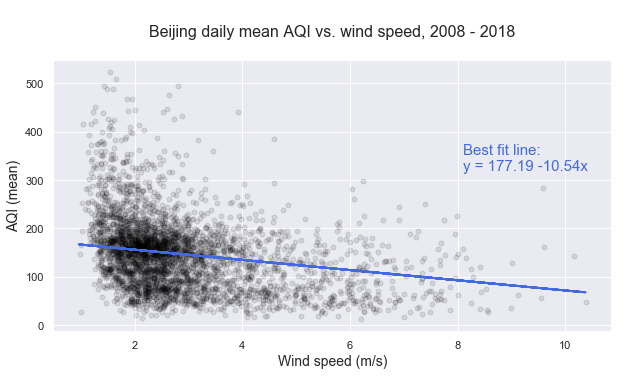

In [84]:
psw = pollution_statevisits_weather.copy()
a, b = best_fit(list(psw.wind_speed.dropna()), list(psw.avg_aqi.dropna()))
X = list(psw.wind_speed)

plt.figure(figsize=(10,5))
plt.scatter(psw.wind_speed, psw.avg_aqi, color='black', alpha=0.1, s=25)
yfit = [a + b * xi for xi in X]
plt.plot(X, yfit,c='royalblue', linewidth=1.9)

plt.text(8.1,320,'Best fit line:\ny = {:.2f} {:.2f}x'.format(a, b), size=15, color='royalblue')
plt.title('\nBeijing daily mean AQI vs. wind speed, 2008 - 2018\n', size=16)
plt.xlabel('Wind speed (m/s)', size=14)
plt.ylabel('AQI (mean)', size=14)
# plt.ylim(0,3900)
plt.savefig(os.getcwd() + '/img/weather/1_aqi_vs_wind_speed.png')

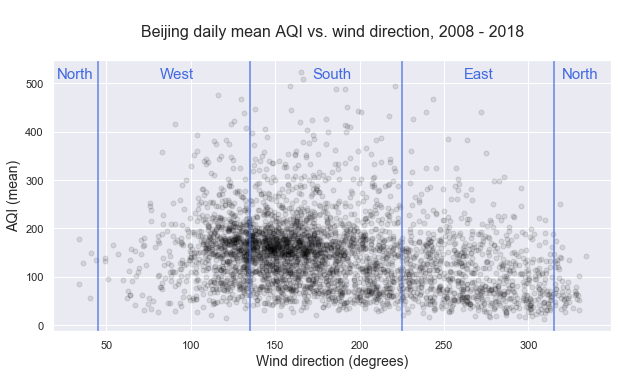

In [85]:
psw = pollution_statevisits_weather.copy()

plt.figure(figsize=(10,5))
plt.scatter(psw.wind_direction, psw.avg_aqi, color='black', alpha=0.1, s=25)
plt.axvline(x=315, alpha=0.8, color='royalblue')
plt.axvline(x=45, alpha=0.8, color='royalblue')
plt.axvline(x=135, alpha=0.8, color='royalblue')
plt.axvline(x=225, alpha=0.8, color='royalblue')
plt.text(82, 510, 'West', size=15, color='royalblue')
plt.text(172, 510, 'South', size=15, color='royalblue')
plt.text(262, 510, 'East', size=15, color='royalblue')
plt.text(320, 510, 'North', size=15, color='royalblue')
plt.text(21, 510, 'North', size=15, color='royalblue')

plt.title('\nBeijing daily mean AQI vs. wind direction, 2008 - 2018\n', size=16)
plt.xlabel('Wind direction (degrees)', size=14)
plt.ylabel('AQI (mean)', size=14)
# plt.ylim(0,3900)
plt.savefig(os.getcwd() + '/img/weather/2_aqi_vs_wind_direction.png')

#### Function to convert wind direction degrees into categorical variable (N, S, E, W)

In [86]:
def convert_wind_direction(x):
    if x >= 315 or x < 45:
        return 'N'
    if x >= 45 and x < 135:
        return 'W'
    if x >= 135 and x < 225:
        return 'S'
    if x >= 225 and x < 315:
        return 'E'

In [87]:
convert_wind_direction(0)

'N'

In [88]:
pollution_statevisits_weather['wind_dir_cat'] = pollution_statevisits_weather.wind_direction.apply(lambda x: convert_wind_direction(x))
pollution_statevisits_weather.tail()

,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit,wind_speed,wind_direction,tempc,atmpres,wind_dir_cat
4013,2018-12-27,36.125000,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,8.982143,326.250000,-9.812500,1043.5625,N
4014,2018-12-28,33.000000,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5.964286,301.071429,-7.196429,1043.9375,E
4015,2018-12-29,38.458333,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.196429,166.600000,-7.000000,1043.7875,S
4016,2018-12-30,46.875000,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.678571,191.891892,-8.794643,1044.1125,S
4017,2018-12-31,111.208333,154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.375000,214.500000,-8.417857,1042.2250,S


# Part V: Import GDP and trade data

# Part VI: Import industrial data from Wind

# Part VII: Analysis

### State visit data: Exploratory analysis

How many days when 0 country representatives in Beijing? How many days with 1 country? 2? etc.

In [89]:
psw = pollution_statevisits_weather.copy()
psw.head(3)

,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit,wind_speed,wind_direction,tempc,atmpres,wind_dir_cat
0,2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.916667,296.000000,-1.258333,1031.8375,E
1,2008-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.208333,281.818182,1.141667,1026.9000,E
2,2008-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.800000,266.363636,-0.292000,1028.4125,E


In [90]:
visit_counts = []
visit_counts.append(psw.country_1.isnull().sum())
for i in range(1,10):
    col = 'country_' + str(i)
    visit_counts.append(((psw[col].isnull() == False).sum()))
visit_counts

[3357, 661, 151, 38, 19, 14, 4, 2, 2, 1]

In [91]:
# labels = ['0 countries','1 country','2 countries','3 countries','4 countries','5 countries','6 countries','7 countries','8 countries','9 countries']
labels = [0,1,2,3,4,5,6,7,8,9]
co_buckets = pd.DataFrame({'bucket':labels, 'num_of_days_co_visits':visit_counts})
co_buckets

,bucket,num_of_days_co_visits
0,0,3357
1,1,661
2,2,151
3,3,38
4,4,19
5,5,14
6,6,4
7,7,2
8,8,2
9,9,1


c:\users\joey\wuran\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\joey\wuran\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


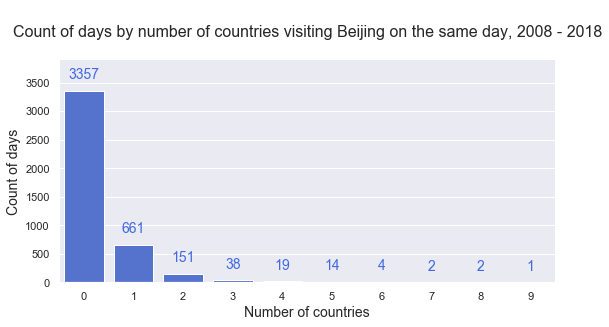

In [92]:
sns.set(style="darkgrid", color_codes=True)

f = sns.factorplot(x="bucket", y="num_of_days_co_visits", data=co_buckets, kind="bar", aspect=2, size=4, color="royalblue", legend=False)

plt.title('\nCount of days by number of countries visiting Beijing on the same day, 2008 - 2018\n', size=16)
plt.xlabel('Number of countries', size=14)
plt.ylabel('Count of days', size=14)
plt.ylim(0,3900)
# plt.yticks([500,1500,3000])

ax = f.ax
for p in ax.patches:
    ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='royalblue', xytext=(0, 16),
                 textcoords='offset points')
f.savefig(os.getcwd() + '/img/chinavitae/1_country_bucket_counts.png')

#### Country visits over time: Which are the top countries coming to Beijing?

In [94]:
countries_raw_data = pd.read_csv('data/countries_clean.csv')
countries_raw_data.head()

,num_code,alpha_2_code,alpha_3_code,country,nationality
0,4,AF,AFG,afghanistan,afghan
1,248,AX,ALA,åland islands,åland island
2,248,AX,ALA,åland islands,aland island
3,8,AL,ALB,albania,albanian
4,12,DZ,DZA,algeria,algerian


In [95]:
xw = pd.DataFrame(countries_raw_data[['nationality','country']]).to_dict()
nationalities = xw['nationality'].values()
countries = xw['country'].values()

Fill `matched_countries` with empty lists `[]` instead of NaN

In [96]:
print(psw.shape)
psw.head(3)

(4018, 19)


,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit,wind_speed,wind_direction,tempc,atmpres,wind_dir_cat
0,2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.916667,296.000000,-1.258333,1031.8375,E
1,2008-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.208333,281.818182,1.141667,1026.9000,E
2,2008-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.800000,266.363636,-0.292000,1028.4125,E


In [97]:
for row in psw.loc[psw.matched_countries.isnull(), 'matched_countries'].index:
    psw.at[row, 'matched_countries'] = []
psw.tail()

,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit,wind_speed,wind_direction,tempc,atmpres,wind_dir_cat
4013,2018-12-27,36.125000,56.0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,8.982143,326.250000,-9.812500,1043.5625,N
4014,2018-12-28,33.000000,43.0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5.964286,301.071429,-7.196429,1043.9375,E
4015,2018-12-29,38.458333,57.0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.196429,166.600000,-7.000000,1043.7875,S
4016,2018-12-30,46.875000,89.0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.678571,191.891892,-8.794643,1044.1125,S
4017,2018-12-31,111.208333,154.0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.375000,214.500000,-8.417857,1042.2250,S


Loop through country columns, subset dataframe, then concat together

In [98]:
combined_cos = pd.DataFrame()
for i in range(1,10):
    col_name = 'country_' + str(i)
    a = psw[['date','avg_aqi','max_aqi','state_visit',col_name]]
    a = a[a[col_name].isnull()==False]
    a = a.rename(columns={col_name:'country'})
    combined_cos = pd.concat([combined_cos,a])
combined_cos = combined_cos.reset_index(drop=True)
combined_cos.shape

(892, 5)

In [99]:
combined_cos.head()

,date,avg_aqi,max_aqi,state_visit,country
0,2008-01-10,NaN,NaN,1,philippines
1,2008-01-16,NaN,NaN,1,finland
2,2008-01-18,NaN,NaN,1,republic of korea
3,2008-01-22,NaN,NaN,1,vietnam
4,2008-01-24,NaN,NaN,1,kazakhstan


Add column for whether country is a G20 member

In [100]:
g20 = ['argentina', 'australia', 'brazil', 'canada', 'china','france','germany','india','indonesia','italy','japan','mexico','republic of korea','russia','saudi arabia','south africa','turkey','united kingdom','united states']
g20[:5]

['argentina', 'australia', 'brazil', 'canada', 'china']

In [101]:
combined_cos['g20_member'] = combined_cos.country.apply(lambda x: x in g20)

In [102]:
combined_cos.head()

,date,avg_aqi,max_aqi,state_visit,country,g20_member
0,2008-01-10,NaN,NaN,1,philippines,False
1,2008-01-16,NaN,NaN,1,finland,False
2,2008-01-18,NaN,NaN,1,republic of korea,True
3,2008-01-22,NaN,NaN,1,vietnam,False
4,2008-01-24,NaN,NaN,1,kazakhstan,False


#### Total visits by country, 2008-2018

In [103]:
c = combined_cos.copy()
country_total_visits = c.groupby('country').size().sort_values(ascending=False)#.plot(kind='bar')
country_total_visits = pd.DataFrame({'country':country_total_visits.index, 'counts':country_total_visits.values})
country_total_visits.head(38)

,country,counts
0,united states,79
1,russia,48
2,france,29
3,germany,24
4,republic of korea,23
5,japan,21
6,vietnam,21
7,united kingdom,21
8,laos,19
9,pakistan,19


c:\users\joey\wuran\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\joey\wuran\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


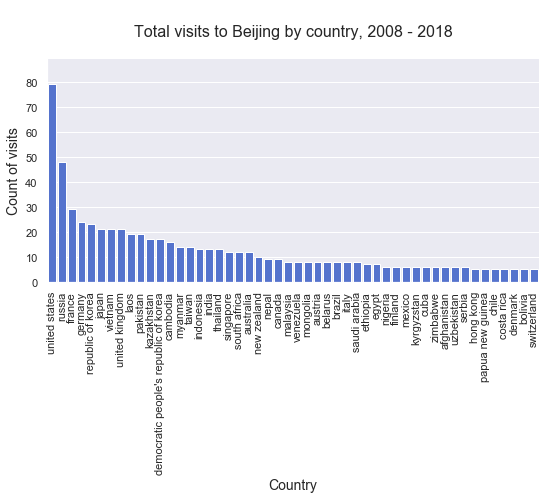

In [104]:
sns.set(style="darkgrid", color_codes=True)

f = sns.factorplot(x="country", y="counts", data=country_total_visits.head(50), kind="bar", aspect=2, size=4, color="royalblue", legend=False)

plt.title('\nTotal visits to Beijing by country, 2008 - 2018\n', size=16)
plt.xlabel('Country', size=14)
plt.ylabel('Count of visits', size=14)
f.set_xticklabels(rotation=90)
plt.ylim(0,89)
f.savefig(os.getcwd() + '/img/chinavitae/2_total_visits_by_country.png')

### Country visits over time, 2008-2018

In [105]:
country_visits_over_time = c.groupby([c.date.apply(lambda x: x.year), c.country]).size()
country_visits_over_time = country_visits_over_time.reset_index()
country_visits_over_time = country_visits_over_time.rename(columns={country_visits_over_time.columns[2]:'counts'})
country_visits_over_time.head()

,date,country,counts
0,2008,algeria,1
1,2008,angola,1
2,2008,australia,1
3,2008,austria,1
4,2008,bangladesh,1


#### United States: Total visits over time

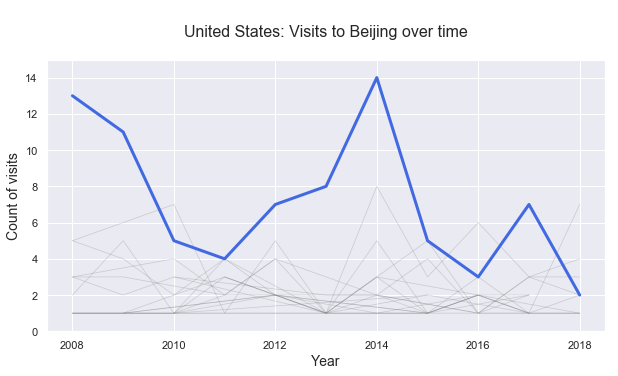

In [106]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in g20:
    if country == 'united states':
        data = country_visits_over_time[country_visits_over_time.country == country]
        f = sns.lineplot(x="date", y="counts", data=data, legend=False, alpha=1.0, color="royalblue", linewidth=3)
    else:
        data = country_visits_over_time[country_visits_over_time.country == country]
        f = sns.lineplot(x="date", y="counts", data=data, legend=False, alpha=0.3, color="grey", size=14)
plt.title('\nUnited States: Visits to Beijing over time\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('Count of visits', size=14)
plt.ylim(0,15)
plt.savefig(os.getcwd() + '/img/chinavitae/3_usa_visits_over_time.png')

#### Russia: Total visits over time

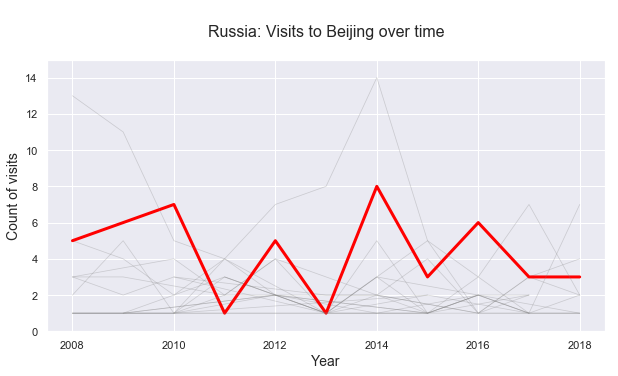

In [107]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in g20:
    if country == 'russia':
        data = country_visits_over_time[country_visits_over_time.country == country]
        f = sns.lineplot(x="date", y="counts", data=data, legend=False, alpha=1.0, color="red", linewidth=3)#, size=4, color="royalblue", legend=False)
    else:
        data = country_visits_over_time[country_visits_over_time.country == country]
        f = sns.lineplot(x="date", y="counts", data=data, legend=False, alpha=0.3, color="grey", size=14)#, size=4, color="royalblue", legend=False)                
plt.title('\nRussia: Visits to Beijing over time\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('Count of visits', size=14)
plt.ylim(0,15)
plt.savefig(os.getcwd() + '/img/chinavitae/4_russia_visits_over_time.png')

#### Japan: Total visits over time

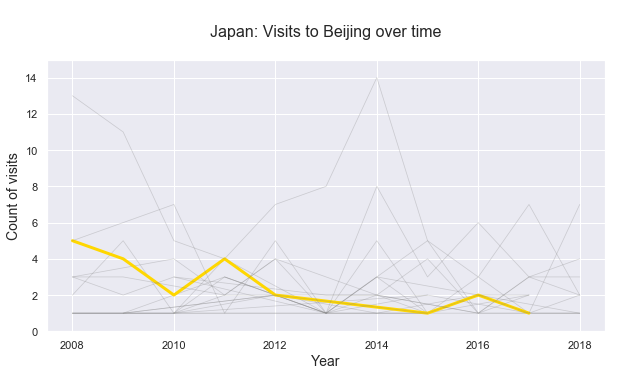

In [108]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in g20:
    if country == 'japan':
        data = country_visits_over_time[country_visits_over_time.country == country]
        f = sns.lineplot(x="date", y="counts", data=data, legend=False, alpha=1.0, color="gold", linewidth=3)#, size=4, color="royalblue", legend=False)
    else:
        data = country_visits_over_time[country_visits_over_time.country == country]
        f = sns.lineplot(x="date", y="counts", data=data, legend=False, alpha=0.3, color="grey", size=14)#, size=4, color="royalblue", legend=False)                
plt.title('\nJapan: Visits to Beijing over time\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('Count of visits', size=14)
plt.ylim(0,15)
plt.savefig(os.getcwd() + '/img/chinavitae/5_japan_visits_over_time.png')

### Average AQI over time, by country

In [530]:
country_aqi_over_time = c.groupby([c.date.apply(lambda x: x.year), c.country, c.g20_member])['avg_aqi'].mean().reset_index()
# country_aqi_over_time = country_aqi_over_time[country_aqi_over_time.g20_member == True]
# country_aqi_over_time['us_flag'] = country_aqi_over_time.country == 'united states'
country_aqi_over_time.head()

,date,country,g20_member,avg_aqi
0,2008,algeria,False,193.458333
1,2008,angola,False,NaN
2,2008,australia,True,169.583333
3,2008,austria,False,52.625000
4,2008,bangladesh,False,163.875000


#### United States: AQI during visits

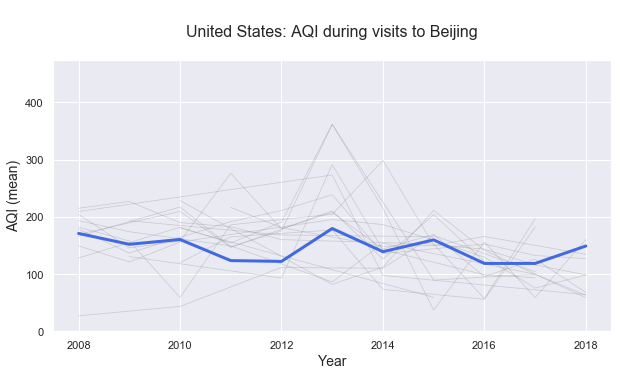

In [531]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in g20:
    if country == 'united states':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend=False, alpha=1.0, color="royalblue", linewidth=3)#, size=4, color="royalblue", legend=False)
    else:
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend=False, alpha=0.3, color="grey", size=14)#, size=4, color="royalblue", legend=False)
        
plt.title('\nUnited States: AQI during visits to Beijing\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('AQI (mean)', size=14)
plt.ylim(0,475)
plt.savefig(os.getcwd() + '/img/chinavitae/6_usa_aqi_during_visits.png')

#### Russia: AQI during visits

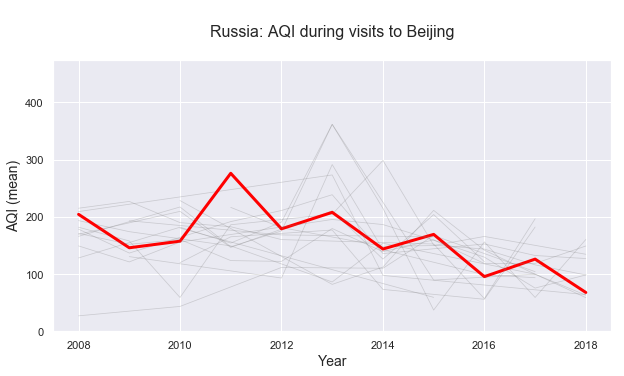

In [532]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in g20:
    if country == 'russia':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=1.0, color="red", linewidth=3)#, size=4, color="royalblue", legend=False)
    else:
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend=False, alpha=0.3, color="grey", size=14)#, size=4, color="royalblue", legend=False)
        
plt.title('\nRussia: AQI during visits to Beijing\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('AQI (mean)', size=14)
# plt.legend(loc='center right')#, bbox_to_anchor=(1.275, 0.5), fontsize=15)
plt.ylim(0,475)
plt.savefig(os.getcwd() + '/img/chinavitae/7_russia_aqi_during_visits.png')

#### Japan: AQI during visits    

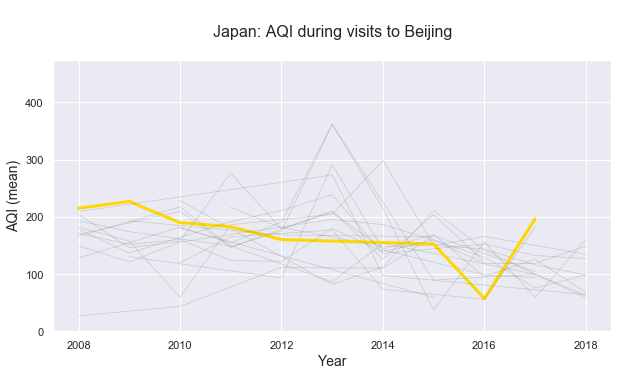

In [533]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in g20:
    if country == 'japan':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend=False, alpha=1.0, color="gold", linewidth=3)#, size=4, color="royalblue", legend=False)
    else:
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend=False, alpha=0.3, color="grey", size=14)#, size=4, color="royalblue", legend=False)
        
plt.title('\nJapan: AQI during visits to Beijing\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('AQI (mean)', size=14)
plt.ylim(0,475)
plt.savefig(os.getcwd() + '/img/chinavitae/8_japan_aqi_during_visits.png')

#### Multiple countries colored

Countries with **at least 20 state visits** from 2008-2018

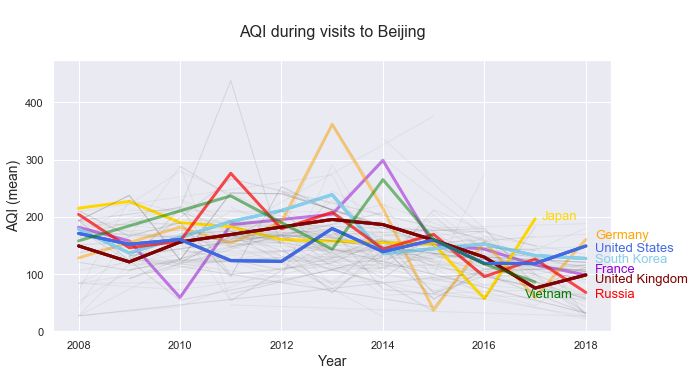

In [534]:
plt.figure(figsize=(10,5))       
sns.set(style="darkgrid", color_codes=True)

for country in list(countries):
    if country == 'united states':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=0.7, color="royalblue", linewidth=3)
    elif country == 'russia':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=0.7, color="red", linewidth=3)
    elif country == 'japan':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=1.0, color="gold", linewidth=3)
    elif country == 'republic of korea':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=1.0, color="skyblue", linewidth=3)
    elif country == 'france':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=0.5, color="darkviolet", linewidth=3)
    elif country == 'germany':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=0.5, color="orange", linewidth=3)
    elif country == 'vietnam':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=0.5, color="green", linewidth=3)
    elif country == 'united kingdom':
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend='brief', alpha=0.5, color="maroon", linewidth=3)
     
    else:
        data = country_aqi_over_time[country_aqi_over_time.country == country]
        f = sns.lineplot(x="date", y="avg_aqi", data=data, legend=False, alpha=0.1, color="grey", linewidth=1)

plt.title('\nAQI during visits to Beijing\n', size=16)
plt.xlabel('Year', size=14)
plt.ylabel('AQI (mean)', size=14)
plt.text(2017.13,195,'Japan', size=13, color='gold')
plt.text(2018.18,140,'United States', size=13, color='royalblue')
plt.text(2018.18,162,'Germany', size=13, color='orange')
plt.text(2018.18,120,'South Korea', size=13, color='skyblue')
plt.text(2018.18,103,'France', size=13, color='darkviolet')
plt.text(2018.18,85,'United Kingdom', size=13, color='maroon')
plt.text(2018.18,60,'Russia', size=13, color='red')
plt.text(2016.8,60,'Vietnam', size=13, color='green')
plt.ylim(0,475)
plt.savefig(os.getcwd() + '/img/chinavitae/9_multicountry_aqi_during_visits.png')

#### Multiple countries colored

Countries with **between 10 and 20 state visits** from 2008-2018

## Statistical Analysis

#### How does AQI (mean) compare on days with state visits vs. days without state visits?

In [115]:
p = psw.copy()
p = p[p.avg_aqi.isnull()==False]
x = p[p.state_visit==1]
x.shape
y = p[p.state_visit==0]
y.shape

(3134, 19)

In [116]:
t, pval, degrees_freedom = ttest_ind(x['avg_aqi'],y['avg_aqi'])
print('The t-statistic is', t)
print('The p-stat of the t test is', pval)

The t-statistic is 0.7939477555194053
The p-stat of the t test is 0.4272759228367524


In [117]:
means_diff = p.groupby(p.state_visit)[['avg_aqi']].mean().reset_index()
means_diff

,state_visit,avg_aqi
0,0,146.678157
1,1,149.177901


c:\users\joey\wuran\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


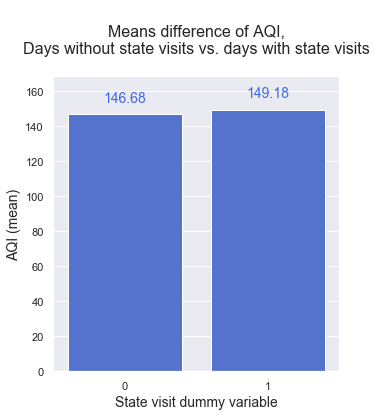

In [118]:
sns.set(style="darkgrid", color_codes=True)

f = sns.factorplot(x="state_visit", y="avg_aqi", data=means_diff, kind="bar", color="royalblue", legend=False)

plt.title('\nMeans difference of AQI,\nDays without state visits vs. days with state visits\n', size=16)
plt.xlabel('State visit dummy variable', size=14)
plt.ylabel('AQI (mean)', size=14)
# f.set_xticklabels(rotation=90)
plt.ylim(0,168)

ax = f.ax
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='royalblue', xytext=(0, 16),
                 textcoords='offset points')
f.savefig(os.getcwd() + '/img/analysis/1_means_diff_aqi.png')

#### United States: T test for means difference

In [119]:
p = psw.copy()
p.shape
p.tail()

,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit,wind_speed,wind_direction,tempc,atmpres,wind_dir_cat
4013,2018-12-27,36.125000,56.0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,8.982143,326.250000,-9.812500,1043.5625,N
4014,2018-12-28,33.000000,43.0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5.964286,301.071429,-7.196429,1043.9375,E
4015,2018-12-29,38.458333,57.0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.196429,166.600000,-7.000000,1043.7875,S
4016,2018-12-30,46.875000,89.0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.678571,191.891892,-8.794643,1044.1125,S
4017,2018-12-31,111.208333,154.0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.375000,214.500000,-8.417857,1042.2250,S


In [120]:
p[p.matched_countries.apply(str).str.contains('united states')].groupby('state_visit')['avg_aqi'].mean()

state_visit
1    146.515243
Name: avg_aqi, dtype: float64

In [121]:
ps[ps.country_1 == 'united states'].groupby(ps.state_visit)[['avg_aqi']].mean()

,avg_aqi
state_visit,
1,142.613572


### Regressing AQI on weather variables, seasonality and `state_visit`

In [449]:
psw = pollution_statevisits_weather.copy()
print(psw.shape)
psw.head()

(4018, 19)


,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,state_visit,wind_speed,wind_direction,tempc,atmpres,wind_dir_cat
0,2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.916667,296.000000,-1.258333,1031.8375,E
1,2008-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.208333,281.818182,1.141667,1026.9000,E
2,2008-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.800000,266.363636,-0.292000,1028.4125,E
3,2008-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.600000,219.090909,-2.692000,1024.2875,S
4,2008-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.391304,208.666667,-2.273913,1020.2125,S


In [450]:
psw = pd.concat([psw, pd.get_dummies(psw.wind_dir_cat,prefix='wind_dir')], axis=1)
psw = psw.drop(columns=['wind_dir_cat'])
psw.columns
print(psw.shape)
psw.head(3)

(4018, 22)


,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,...,country_9,state_visit,wind_speed,wind_direction,tempc,atmpres,wind_dir_E,wind_dir_N,wind_dir_S,wind_dir_W
0,2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,3.916667,296.000000,-1.258333,1031.8375,1,0,0,0
1,2008-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,3.208333,281.818182,1.141667,1026.9000,1,0,0,0
2,2008-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,2.800000,266.363636,-0.292000,1028.4125,1,0,0,0


Convert NaNs to `[]`

In [451]:
for row in psw.loc[psw.matched_countries.isnull(), 'matched_countries'].index:
    psw.at[row, 'matched_countries'] = []
psw.tail()

,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,...,country_9,state_visit,wind_speed,wind_direction,tempc,atmpres,wind_dir_E,wind_dir_N,wind_dir_S,wind_dir_W
4013,2018-12-27,36.125000,56.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,8.982143,326.250000,-9.812500,1043.5625,0,1,0,0
4014,2018-12-28,33.000000,43.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,5.964286,301.071429,-7.196429,1043.9375,1,0,0,0
4015,2018-12-29,38.458333,57.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,3.196429,166.600000,-7.000000,1043.7875,0,0,1,0
4016,2018-12-30,46.875000,89.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,1.678571,191.891892,-8.794643,1044.1125,0,0,1,0
4017,2018-12-31,111.208333,154.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,1.375000,214.500000,-8.417857,1042.2250,0,0,1,0


Code variable for whether any g20 countries are in `matched_countries`

In [452]:
def match_g20(other_list):
    return not set(other_list).isdisjoint(g20)
print(match_g20(['algeria', 'japan']))

True


In [453]:
psw['g20_visit'] = psw.matched_countries.apply(match_g20).astype(int)
psw.tail()

,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,...,state_visit,wind_speed,wind_direction,tempc,atmpres,wind_dir_E,wind_dir_N,wind_dir_S,wind_dir_W,g20_visit
4013,2018-12-27,36.125000,56.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,8.982143,326.250000,-9.812500,1043.5625,0,1,0,0,0
4014,2018-12-28,33.000000,43.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,5.964286,301.071429,-7.196429,1043.9375,1,0,0,0,0
4015,2018-12-29,38.458333,57.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,3.196429,166.600000,-7.000000,1043.7875,0,0,1,0,0
4016,2018-12-30,46.875000,89.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,1.678571,191.891892,-8.794643,1044.1125,0,0,1,0,0
4017,2018-12-31,111.208333,154.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,1.375000,214.500000,-8.417857,1042.2250,0,0,1,0,0


Try coding a USA dummy variable

In [454]:
psw['usa_visit'] = psw.matched_countries.apply(lambda x: 'united states' in x).astype(int)
psw.tail()

,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,...,wind_speed,wind_direction,tempc,atmpres,wind_dir_E,wind_dir_N,wind_dir_S,wind_dir_W,g20_visit,usa_visit
4013,2018-12-27,36.125000,56.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,8.982143,326.250000,-9.812500,1043.5625,0,1,0,0,0,0
4014,2018-12-28,33.000000,43.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,5.964286,301.071429,-7.196429,1043.9375,1,0,0,0,0,0
4015,2018-12-29,38.458333,57.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,3.196429,166.600000,-7.000000,1043.7875,0,0,1,0,0,0
4016,2018-12-30,46.875000,89.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,1.678571,191.891892,-8.794643,1044.1125,0,0,1,0,0,0
4017,2018-12-31,111.208333,154.0,[],NaN,NaN,NaN,NaN,NaN,NaN,...,1.375000,214.500000,-8.417857,1042.2250,0,0,1,0,0,0


Code dummies for other country visits

In [455]:
psw['russia_visit'] = psw.matched_countries.apply(lambda x: 'russia' in x).astype(int)
psw['japan_visit'] = psw.matched_countries.apply(lambda x: 'japan' in x).astype(int)
psw['france_visit'] = psw.matched_countries.apply(lambda x: 'france' in x).astype(int)
psw['germany_visit'] = psw.matched_countries.apply(lambda x: 'germany' in x).astype(int)
psw['rok_visit'] = psw.matched_countries.apply(lambda x: 'republic of korea' in x).astype(int)
psw['vietnam_visit'] = psw.matched_countries.apply(lambda x: 'vietnam' in x).astype(int)
psw['uk_visit'] = psw.matched_countries.apply(lambda x: 'united kingdom' in x).astype(int)
psw.head()

,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,...,wind_dir_W,g20_visit,usa_visit,russia_visit,japan_visit,france_visit,germany_visit,rok_visit,vietnam_visit,uk_visit
0,2008-01-01,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2008-01-02,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2008-01-03,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2008-01-04,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2008-01-05,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


#### Creating a subset US dataframe for conditional regressions

In [456]:
usa_subset = pd.DataFrame(columns=psw.columns)
for i, row in psw.iterrows():
    if 'united states' in row['matched_countries']:
        usa_subset = usa_subset.append(row.to_dict(), ignore_index=True)

usa_subset.tail()

,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,...,wind_dir_W,g20_visit,usa_visit,russia_visit,japan_visit,france_visit,germany_visit,rok_visit,vietnam_visit,uk_visit
74,2017-11-09,128.833333,163.0,[united states],united states,NaN,NaN,NaN,NaN,NaN,...,0,1,1,0,0,0,0,0,0,0
75,2017-11-10,35.750000,160.0,[united states],united states,NaN,NaN,NaN,NaN,NaN,...,0,1,1,0,0,0,0,0,0,0
76,2017-11-29,44.833333,83.0,[united states],united states,NaN,NaN,NaN,NaN,NaN,...,0,1,1,0,0,0,0,0,0,0
77,2018-03-27,223.166667,248.0,[united states],united states,NaN,NaN,NaN,NaN,NaN,...,0,1,1,0,0,0,0,0,0,0
78,2018-06-27,74.958333,152.0,[united states],united states,NaN,NaN,NaN,NaN,NaN,...,0,1,1,0,0,0,0,0,0,0


#### Russia subset

In [457]:
russia_subset = pd.DataFrame(columns=psw.columns)
for i, row in psw.iterrows():
    if 'russia' in row['matched_countries']:
        russia_subset = russia_subset.append(row.to_dict(), ignore_index=True)

russia_subset.tail()

,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,...,wind_dir_W,g20_visit,usa_visit,russia_visit,japan_visit,france_visit,germany_visit,rok_visit,vietnam_visit,uk_visit
43,2017-10-31,132.083333,185.0,[russia],russia,NaN,NaN,NaN,NaN,NaN,...,0,1,0,1,0,0,0,0,0,0
44,2017-11-01,146.541667,189.0,[russia],russia,NaN,NaN,NaN,NaN,NaN,...,1,1,0,1,0,0,0,0,0,0
45,2018-04-23,58.833333,80.0,"[kazakhstan, russia, pakistan, india, kyrgyzstan]",kazakhstan,russia,pakistan,india,kyrgyzstan,NaN,...,0,1,0,1,0,0,0,0,0,0
46,2018-06-08,66.291667,79.0,[russia],russia,NaN,NaN,NaN,NaN,NaN,...,0,1,0,1,0,0,0,0,0,0
47,2018-11-07,78.416667,132.0,[russia],russia,NaN,NaN,NaN,NaN,NaN,...,0,1,0,1,0,0,0,0,0,0


#### Japan subset

In [458]:
japan_subset = pd.DataFrame(columns=psw.columns)
for i, row in psw.iterrows():
    if 'japan' in row['matched_countries']:
        japan_subset = japan_subset.append(row.to_dict(), ignore_index=True)

japan_subset.tail()

,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,...,wind_dir_W,g20_visit,usa_visit,russia_visit,japan_visit,france_visit,germany_visit,rok_visit,vietnam_visit,uk_visit
16,2012-05-14,121.416667,174.0,"[republic of korea, japan]",republic of korea,japan,NaN,NaN,NaN,NaN,...,0,1,0,0,1,0,0,1,0,0
17,2015-04-14,152.541667,169.0,[japan],japan,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,1,0,0,0,0,0
18,2016-03-30,70.041667,153.0,[japan],japan,NaN,NaN,NaN,NaN,NaN,...,1,1,0,0,1,0,0,0,0,0
19,2016-08-25,44.208333,166.0,[japan],japan,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,1,0,0,0,0,0
20,2017-11-21,196.625000,237.0,[japan],japan,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,1,0,0,0,0,0


#### Export table of summary states of main variables

In [459]:
psw.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_aqi,3764.0,147.096552,72.106973,12.958333,93.864583,146.000000,180.541667,523.750000
max_aqi,3764.0,202.823326,92.298988,20.000000,156.000000,181.000000,237.000000,733.000000
state_visit,4018.0,0.164510,0.370784,0.000000,0.000000,0.000000,0.000000,1.000000
wind_speed,3992.0,2.855778,1.372471,0.958333,1.958333,2.458333,3.270833,10.375000
wind_direction,3992.0,182.998646,57.628457,33.666667,140.541667,169.878049,219.109848,333.958333
tempc,3992.0,12.885294,11.476050,-14.755357,1.865438,14.393452,23.555804,33.147917
atmpres,3990.0,1016.568320,10.380945,993.575000,1007.775000,1016.181250,1024.921875,1044.425000
wind_dir_E,4018.0,0.215530,0.411241,0.000000,0.000000,0.000000,0.000000,1.000000
wind_dir_N,4018.0,0.016675,0.128066,0.000000,0.000000,0.000000,0.000000,1.000000
wind_dir_S,4018.0,0.555998,0.496916,0.000000,0.000000,1.000000,1.000000,1.000000


In [460]:
# psw.describe().T.to_excel('img/analysis/0_summary_stats.xlsx')

In [461]:
psw['year'] = psw.date.apply(lambda x: x.year)
psw['month'] = psw.date.apply(lambda x: x.month)
psw = pd.concat([psw, pd.get_dummies(psw.year, prefix='year')], axis=1) # add year dummy
psw = pd.concat([psw, pd.get_dummies(psw.month, prefix='month')], axis=1) # add month dummy
psw.head()

,date,avg_aqi,max_aqi,matched_countries,country_1,country_2,country_3,country_4,country_5,country_6,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2008-01-01,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2008-01-02,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2008-01-03,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2008-01-04,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2008-01-05,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


#### Computing interaction terms

In [462]:
# wind_speed x wind_direction
interaction_terms_df = pd.DataFrame()
a = psw.filter(regex='^wind_speed')
b = psw.filter(regex='^wind_dir_')
for col1 in b:
    for col2 in a:
        interaction_terms_df[col2 + '_x_' + col1] = psw[col1].mul(psw[col2])
print(interaction_terms_df.shape)
interaction_terms_df.head()

(4018, 4)


,wind_speed_x_wind_dir_E,wind_speed_x_wind_dir_N,wind_speed_x_wind_dir_S,wind_speed_x_wind_dir_W
0,3.916667,0.0,0.000000,0.0
1,3.208333,0.0,0.000000,0.0
2,2.800000,0.0,0.000000,0.0
3,0.000000,0.0,1.600000,0.0
4,0.000000,0.0,1.391304,0.0


In [463]:
# wind_speed x year
a = p.filter(regex='^wind_speed')
b = p.filter(regex='^year')
for col1 in b:
    for col2 in a:
        interaction_terms_df[col2 + '_x_' + col1] = p[col1].mul(p[col2])
print(interaction_terms_df.shape)
interaction_terms_df.head()

(4018, 14)


,wind_speed_x_wind_dir_E,wind_speed_x_wind_dir_N,wind_speed_x_wind_dir_S,wind_speed_x_wind_dir_W,wind_speed_x_year_2009,wind_speed_x_year_2010,wind_speed_x_year_2011,wind_speed_x_year_2012,wind_speed_x_year_2013,wind_speed_x_year_2014,wind_speed_x_year_2015,wind_speed_x_year_2016,wind_speed_x_year_2017,wind_speed_x_year_2018
0,3.916667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.208333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.800000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,1.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,1.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [464]:
# wind_speed x month
a = p.filter(regex='^wind_speed')
b = p.filter(regex='^month')
for col1 in b:
    for col2 in a:
        interaction_terms_df[col2 + '_x_' + col1] = p[col1].mul(p[col2])
print(interaction_terms_df.shape)
interaction_terms_df.head()

(4018, 25)


,wind_speed_x_wind_dir_E,wind_speed_x_wind_dir_N,wind_speed_x_wind_dir_S,wind_speed_x_wind_dir_W,wind_speed_x_year_2009,wind_speed_x_year_2010,wind_speed_x_year_2011,wind_speed_x_year_2012,wind_speed_x_year_2013,wind_speed_x_year_2014,...,wind_speed_x_month_3,wind_speed_x_month_4,wind_speed_x_month_5,wind_speed_x_month_6,wind_speed_x_month_7,wind_speed_x_month_8,wind_speed_x_month_9,wind_speed_x_month_10,wind_speed_x_month_11,wind_speed_x_month_12
0,3.916667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.208333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.800000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,1.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,1.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [465]:
# year x month
a = p.filter(regex='^year')
b = p.filter(regex='^month')
for col1 in b:
    for col2 in a:
        interaction_terms_df[col2 + '_x_' + col1] = p[col1].mul(p[col2])
print(interaction_terms_df.shape)
interaction_terms_df.head()

(4018, 135)


,wind_speed_x_wind_dir_E,wind_speed_x_wind_dir_N,wind_speed_x_wind_dir_S,wind_speed_x_wind_dir_W,wind_speed_x_year_2009,wind_speed_x_year_2010,wind_speed_x_year_2011,wind_speed_x_year_2012,wind_speed_x_year_2013,wind_speed_x_year_2014,...,year_2009_x_month_12,year_2010_x_month_12,year_2011_x_month_12,year_2012_x_month_12,year_2013_x_month_12,year_2014_x_month_12,year_2015_x_month_12,year_2016_x_month_12,year_2017_x_month_12,year_2018_x_month_12
0,3.916667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3.208333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2.800000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.0,1.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.0,1.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [466]:
# wind_direction x year
a = p.filter(regex='^wind_dir_')
b = p.filter(regex='^year')
for col1 in b:
    for col2 in a:
        interaction_terms_df[col2 + '_x_' + col1] = p[col1].mul(p[col2])
print(interaction_terms_df.shape)
interaction_terms_df.head()

(4018, 165)


,wind_speed_x_wind_dir_E,wind_speed_x_wind_dir_N,wind_speed_x_wind_dir_S,wind_speed_x_wind_dir_W,wind_speed_x_year_2009,wind_speed_x_year_2010,wind_speed_x_year_2011,wind_speed_x_year_2012,wind_speed_x_year_2013,wind_speed_x_year_2014,...,wind_dir_W_x_year_2015,wind_dir_S_x_year_2016,wind_dir_E_x_year_2016,wind_dir_W_x_year_2016,wind_dir_S_x_year_2017,wind_dir_E_x_year_2017,wind_dir_W_x_year_2017,wind_dir_S_x_year_2018,wind_dir_E_x_year_2018,wind_dir_W_x_year_2018
0,3.916667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3.208333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2.800000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.0,1.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.0,1.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [467]:
# wind_direction x month
a = p.filter(regex='^wind_dir_')
b = p.filter(regex='^month')
for col1 in b:
    for col2 in a:
        interaction_terms_df[col2 + '_x_' + col1] = p[col1].mul(p[col2])
print(interaction_terms_df.shape)
interaction_terms_df.head()

(4018, 198)


,wind_speed_x_wind_dir_E,wind_speed_x_wind_dir_N,wind_speed_x_wind_dir_S,wind_speed_x_wind_dir_W,wind_speed_x_year_2009,wind_speed_x_year_2010,wind_speed_x_year_2011,wind_speed_x_year_2012,wind_speed_x_year_2013,wind_speed_x_year_2014,...,wind_dir_W_x_month_9,wind_dir_S_x_month_10,wind_dir_E_x_month_10,wind_dir_W_x_month_10,wind_dir_S_x_month_11,wind_dir_E_x_month_11,wind_dir_W_x_month_11,wind_dir_S_x_month_12,wind_dir_E_x_month_12,wind_dir_W_x_month_12
0,3.916667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3.208333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2.800000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.0,1.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.0,1.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [468]:
wind_interaction_terms = interaction_terms_df.filter(regex='^wind_speed_x_wind_dir_')
wind_interaction_terms = wind_interaction_terms.drop(columns=['wind_speed_x_wind_dir_N'])
year_month_dummies = interaction_terms_df.filter(regex='^year_.*_x_month_.*')

#### Starting to build regression model inputs

In [470]:
p = psw.copy()
p = p[['avg_aqi',
 'max_aqi',
 'state_visit',
 'g20_visit',
 'usa_visit',
 'russia_visit',
 'japan_visit',
 'france_visit',
 'germany_visit',
 'rok_visit',
 'vietnam_visit',
 'uk_visit',
 'wind_speed',
 'wind_direction',
 'tempc',
 'atmpres',
#  'wind_dir_N', # base case
 'wind_dir_S',
 'wind_dir_E',
 'wind_dir_W',
#  'year_2008', # base case
 'year_2009',
 'year_2010',
 'year_2011',
 'year_2012',
 'year_2013',
 'year_2014',
 'year_2015',
 'year_2016',
 'year_2017',
 'year_2018',
#  'month_1', # base case
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12']
     ]

In [471]:
print(p.shape)
p.tail()

(4018, 40)


,avg_aqi,max_aqi,state_visit,g20_visit,usa_visit,russia_visit,japan_visit,france_visit,germany_visit,rok_visit,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
4013,36.125000,56.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4014,33.000000,43.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4015,38.458333,57.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4016,46.875000,89.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4017,111.208333,154.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [472]:
year_dummies = ['year_2009', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017', 'year_2018']
month_dummies = ['month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12']
p = sm.add_constant(p, prepend=False) # add constant for modeling
p.head()

,avg_aqi,max_aqi,state_visit,g20_visit,usa_visit,russia_visit,japan_visit,france_visit,germany_visit,rok_visit,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,const
0,NaN,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,NaN,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,NaN,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,NaN,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,NaN,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


## OLS results
- `avg_aqi` as dependent variable
- `state_visit` as main independent variable
- `hxwl_matched` (dataset for meetings with the Chinese president/premier)

In [497]:
def run_regressions_for_country(country_name, filenumber):
    col = country_name + '_visit'
    reg1 = sm.OLS(p['avg_aqi'], p[['const',col,'wind_speed','wind_dir_S','wind_dir_E','wind_dir_W','tempc','atmpres']],
                  missing='drop').fit()
    reg2 = sm.OLS(p['avg_aqi'], p[['const',col,'wind_speed','wind_dir_S','wind_dir_E','wind_dir_W','tempc','atmpres'] 
                                  + year_dummies + month_dummies],
                  missing='drop').fit()
    reg3 = sm.OLS(p['avg_aqi'], pd.concat([p[['const',col,'wind_speed','wind_dir_S','wind_dir_E','wind_dir_W','tempc','atmpres'] 
                                  + year_dummies + month_dummies], wind_interaction_terms], axis=1),
                  missing='drop').fit()
    ols_output = summary_col([reg1, reg2, reg3], 
                             stars=True, 
                             model_names=['AQI\n(1)','AQI\n(2)','AQI\n(3)'], 
                             float_format='%.3f',
                             regressor_order=([col,'wind_speed','wind_dir_S','wind_dir_E','wind_dir_W',
                                              'tempc','atmpres',
                                              'wind_speed_x_wind_dir_N','wind_speed_x_wind_dir_S',
                                              'wind_speed_x_wind_dir_E','wind_speed_x_wind_dir_W'
                                              ]),
                             info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                'R2':lambda x: "{:.2f}".format(x.rsquared)}
                            )
    print(ols_output)
    filepath = "img/analysis/" + filenumber + "_results_" + country_name + ".xls"
    f = open(filepath,'w')
    f.write(ols_output.as_text())
    f.close()
    print('\nSaved', filepath)

In [511]:
# run_regressions_for_country('state','2')

In [500]:
run_regressions_for_country('usa','3')


                            AQI         AQI         AQI    
                            (1)         (2)         (3)    
-----------------------------------------------------------
usa_visit               -1.530      -12.033     -11.938*   
                        (7.936)     (7.324)     (7.253)    
wind_speed              -17.051***  -17.615***  -0.043     
                        (1.045)     (1.013)     (4.712)    
wind_dir_S              -3.245      -10.528     131.697*** 
                        (9.983)     (9.274)     (33.651)   
wind_dir_E              -20.845**   -29.472***  65.259*    
                        (9.366)     (8.659)     (33.923)   
wind_dir_W              1.429       -3.286      144.882*** 
                        (10.261)    (9.520)     (34.110)   
tempc                   -3.648***   1.909***    2.090***   
                        (0.197)     (0.346)     (0.344)    
atmpres                 -3.679***   -3.298***   -3.197***  
                        (0.215)     (0.

In [502]:
run_regressions_for_country('russia','4')


                            AQI         AQI         AQI    
                            (1)         (2)         (3)    
-----------------------------------------------------------
russia_visit            3.428       -2.724      -2.774     
                        (9.838)     (9.069)     (8.977)    
wind_speed              -17.041***  -17.618***  -0.073     
                        (1.046)     (1.013)     (4.713)    
wind_dir_S              -3.230      -10.431     131.718*** 
                        (9.982)     (9.277)     (33.664)   
wind_dir_E              -20.849**   -29.351***  65.143*    
                        (9.366)     (8.662)     (33.936)   
wind_dir_W              1.442       -3.229      144.507*** 
                        (10.261)    (9.523)     (34.121)   
tempc                   -3.651***   1.888***    2.069***   
                        (0.197)     (0.346)     (0.344)    
atmpres                 -3.682***   -3.295***   -3.195***  
                        (0.215)     (0.

In [503]:
run_regressions_for_country('japan','5')


                            AQI         AQI         AQI    
                            (1)         (2)         (3)    
-----------------------------------------------------------
japan_visit             34.740**    22.763      23.182*    
                        (15.307)    (14.125)    (13.983)   
wind_speed              -17.061***  -17.618***  -0.085     
                        (1.045)     (1.013)     (4.711)    
wind_dir_S              -3.502      -10.642     131.394*** 
                        (9.976)     (9.275)     (33.651)   
wind_dir_E              -20.950**   -29.463***  64.935*    
                        (9.360)     (8.659)     (33.922)   
wind_dir_W              1.313       -3.368      144.436*** 
                        (10.254)    (9.520)     (34.109)   
tempc                   -3.653***   1.871***    2.053***   
                        (0.197)     (0.346)     (0.344)    
atmpres                 -3.683***   -3.301***   -3.201***  
                        (0.215)     (0.

In [505]:
run_regressions_for_country('france','6')


                            AQI         AQI         AQI    
                            (1)         (2)         (3)    
-----------------------------------------------------------
france_visit            13.653      9.116       5.790      
                        (12.296)    (11.340)    (11.232)   
wind_speed              -17.057***  -17.619***  -0.135     
                        (1.045)     (1.013)     (4.714)    
wind_dir_S              -3.143      -10.364     131.280*** 
                        (9.981)     (9.277)     (33.669)   
wind_dir_E              -20.740**   -29.289***  64.779*    
                        (9.365)     (8.662)     (33.937)   
wind_dir_W              1.531       -3.168      144.085*** 
                        (10.260)    (9.523)     (34.127)   
tempc                   -3.642***   1.881***    2.064***   
                        (0.197)     (0.346)     (0.344)    
atmpres                 -3.674***   -3.292***   -3.194***  
                        (0.215)     (0.

In [506]:
run_regressions_for_country('germany','7')


                            AQI         AQI         AQI    
                            (1)         (2)         (3)    
-----------------------------------------------------------
germany_visit           34.478***   32.659***   32.220***  
                        (13.265)    (12.212)    (12.090)   
wind_speed              -17.093***  -17.645***  -0.104     
                        (1.044)     (1.012)     (4.709)    
wind_dir_S              -3.626      -10.831     131.343*** 
                        (9.975)     (9.269)     (33.631)   
wind_dir_E              -21.113**   -29.680***  64.813*    
                        (9.358)     (8.654)     (33.902)   
wind_dir_W              1.077       -3.584      143.884*** 
                        (10.253)    (9.515)     (34.089)   
tempc                   -3.662***   1.879***    2.061***   
                        (0.197)     (0.346)     (0.343)    
atmpres                 -3.691***   -3.313***   -3.213***  
                        (0.215)     (0.

In [507]:
run_regressions_for_country('rok','8')


                            AQI         AQI         AQI    
                            (1)         (2)         (3)    
-----------------------------------------------------------
rok_visit               21.283      13.459      13.307     
                        (13.856)    (12.767)    (12.644)   
wind_speed              -17.051***  -17.608***  -0.029     
                        (1.045)     (1.013)     (4.713)    
wind_dir_S              -3.000      -10.264     132.037*** 
                        (9.981)     (9.277)     (33.660)   
wind_dir_E              -20.548**   -29.166***  65.607*    
                        (9.365)     (8.663)     (33.934)   
wind_dir_W              1.627       -3.098      145.053*** 
                        (10.258)    (9.523)     (34.121)   
tempc                   -3.645***   1.878***    2.059***   
                        (0.197)     (0.346)     (0.344)    
atmpres                 -3.676***   -3.297***   -3.197***  
                        (0.215)     (0.

In [508]:
run_regressions_for_country('vietnam','9')


                            AQI         AQI         AQI    
                            (1)         (2)         (3)    
-----------------------------------------------------------
vietnam_visit           32.553**    25.011*     22.322     
                        (14.914)    (13.754)    (13.620)   
wind_speed              -17.055***  -17.618***  -0.087     
                        (1.045)     (1.012)     (4.711)    
wind_dir_S              -3.406      -10.538     131.398*** 
                        (9.977)     (9.273)     (33.651)   
wind_dir_E              -21.143**   -29.576***  64.998*    
                        (9.361)     (8.659)     (33.922)   
wind_dir_W              1.408       -3.238      144.375*** 
                        (10.254)    (9.519)     (34.109)   
tempc                   -3.665***   1.855***    2.039***   
                        (0.197)     (0.346)     (0.344)    
atmpres                 -3.696***   -3.310***   -3.209***  
                        (0.215)     (0.

In [509]:
run_regressions_for_country('uk','10')


                            AQI         AQI         AQI    
                            (1)         (2)         (3)    
-----------------------------------------------------------
uk_visit                -20.081     -18.170     -13.555    
                        (14.908)    (13.750)    (13.625)   
wind_speed              -17.063***  -17.630***  -0.211     
                        (1.045)     (1.013)     (4.714)    
wind_dir_S              -3.544      -10.753     130.452*** 
                        (9.983)     (9.278)     (33.679)   
wind_dir_E              -21.081**   -29.627***  64.124*    
                        (9.366)     (8.662)     (33.943)   
wind_dir_W              1.180       -3.490      143.414*** 
                        (10.260)    (9.523)     (34.132)   
tempc                   -3.651***   1.892***    2.071***   
                        (0.197)     (0.346)     (0.344)    
atmpres                 -3.680***   -3.298***   -3.198***  
                        (0.215)     (0.

In [512]:
run_regressions_for_country('g20','11')


                            AQI         AQI         AQI    
                            (1)         (2)         (3)    
-----------------------------------------------------------
g20_visit               5.719       -1.384      -0.840     
                        (4.014)     (3.716)     (3.679)    
wind_speed              -17.063***  -17.613***  -0.084     
                        (1.045)     (1.013)     (4.713)    
wind_dir_S              -3.174      -10.466     131.580*** 
                        (9.980)     (9.277)     (33.664)   
wind_dir_E              -20.733**   -29.402***  65.005*    
                        (9.364)     (8.662)     (33.935)   
wind_dir_W              1.499       -3.260      144.367*** 
                        (10.258)    (9.523)     (34.123)   
tempc                   -3.654***   1.893***    2.071***   
                        (0.197)     (0.347)     (0.344)    
atmpres                 -3.681***   -3.296***   -3.196***  
                        (0.215)     (0.

In [643]:
beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}
"""
endtex = """
\end{document}"""

f = open('img/analysis/2_results_summary.tex', 'w')
f.write(beginningtex)
f.write(results.summary().as_latex())
f.write(endtex)
f.close()

## Next Steps:

- Import additional data (i.e. weather data, GDP, trade volumes)
- Continue data exploratoration
- Proceed with statistical modeling (i.e. time series analysis, predict AQI on a given day)